<a href="https://colab.research.google.com/github/d-roland/toxicityDetection/blob/main/CS224n_Toxicity_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from tqdm import tqdm, trange
from collections import Counter, defaultdict
from wordcloud import WordCloud
import string
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
import gensim
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Concatenate, concatenate, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from datetime import datetime
from statistics import mean
!pip install torch==1.4.0
import torch
import random
import datetime
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 753.4MB 20kB/s 
ERROR: torchvision 0.9.0+cu101 has requirement torch==1.8.0, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101


In [3]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

### Loading and merging datasets

In [4]:
colnames=['Sentence', 'Type', 'Level', 'Target'] 
hateful = pd.read_csv('/content/drive/My Drive/CS224n_Project/Hatefuls.csv', names=colnames, header=None)
hateful.shape

(194593, 4)

In [5]:
hateful.describe()

,Sentence,Type,Level,Target
count,194572,194593,194593,194593
unique,63324,14,4,6
top,tg,Insult,VERY_HIGH,USER
freq,1364,116947,66901,96997


In [6]:
#Adding a class column prior to merging with neutral data
hateful["Class"] = 1
hateful.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [7]:
hateful.Sentence = hateful.Sentence.astype(str)

In [8]:
neutral = pd.read_csv('/content/drive/My Drive/CS224n_Project/Neutrals_200k.csv', names=colnames, header=None)
neutral.shape

(200000, 4)

In [9]:
neutral.Sentence = neutral.Sentence.astype(str)

In [10]:
#Adding a class column prior to merging with toxic data
neutral["Class"] = 0
neutral.head()

,Sentence,Type,Level,Target,Class
0,"Chui désolé, mais quand un film de science-fic...",Neutral,NONE,UNDEFINED,0
1,Mdrrr junior bvndo,Neutral,NONE,UNDEFINED,0
2,baham je taimz,Neutral,NONE,UNDEFINED,0
3,Meilleurs rappeurs de tout les temps 😂😂😂 je ri...,Neutral,NONE,UNDEFINED,0
4,7up❤️,Neutral,NONE,UNDEFINED,0


In [11]:
dataset = hateful.append([neutral], ignore_index=True)
dataset.shape

(394593, 5)

In [12]:
dataset.head()

,Sentence,Type,Level,Target,Class
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1
3,T un kiko mdr,Insult,LOW,USER,1
4,Moi mdr t trop nul,Hate,LOW,USER,1


In [13]:
dataset.tail()

,Sentence,Type,Level,Target,Class
394588,@studiosushi @Chitori_Bocchi evangelionnnnnnnn...,Neutral,NONE,UNDEFINED,0
394589,J'ai kiffer les 2 Baby sitter c drôle et horri...,Neutral,NONE,UNDEFINED,0
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0
394591,venez on fait l' aphalbet,Neutral,NONE,UNDEFINED,0
394592,Bah oui 80% de la police france est pro RN ...,Neutral,NONE,UNDEFINED,0


### Analyzing dataset

In [14]:
dataset.groupby(['Target']).count()

,Sentence,Type,Level,Class
Target,,,,
AUTHOR_OF_COMMENT,2547,2547,2547,2547
EVERYONE,16603,16603,16603,16603
GROUP,36083,36083,36083,36083
NO_ONE,1,1,1,1
SINGLE_PERSON,36128,36128,36128,36128
UNDEFINED,199191,199191,199191,199191
USER,97574,97574,97574,97574
USER_FAMILY,6466,6466,6466,6466


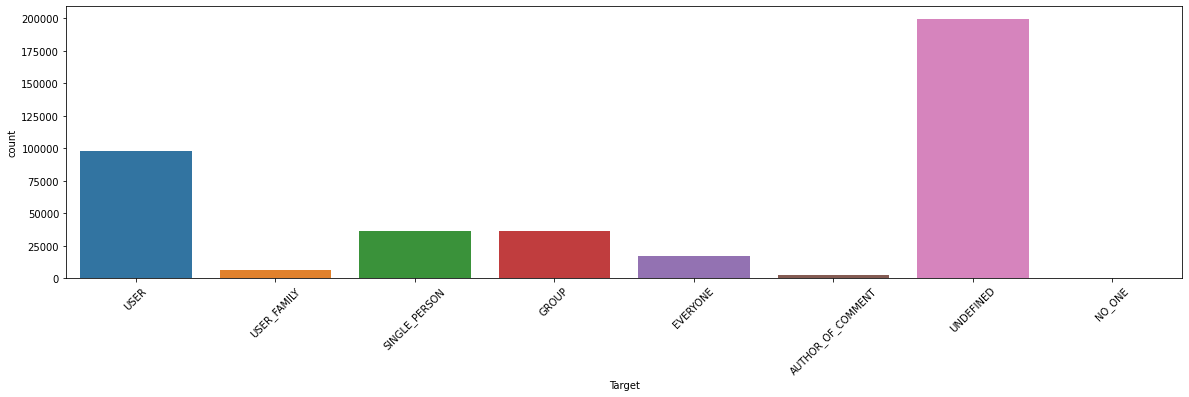

In [15]:
plt.figure(figsize=(20,5))
chart = sns.countplot("Target", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [16]:
dataset.groupby(['Type']).count()

,Sentence,Level,Target,Class
Type,,,,
Ads,27,27,27,27
Critics,15,15,15,15
Hate,37293,37293,37293,37293
Homophobia,12256,12256,12256,12256
Insult,116947,116947,116947,116947
Misogyny,6,6,6,6
Mockery,13950,13950,13950,13950
Moral Harassment,1583,1583,1583,1583
Neutral,200009,200009,200009,200009


In [17]:
dataset.groupby(['Level']).count()

,Sentence,Type,Target,Class
Level,,,,
HIGH,53358,53358,53358,53358
LOW,28016,28016,28016,28016
MEDIUM,46880,46880,46880,46880
NONE,199189,199189,199189,199189
VERY_HIGH,67150,67150,67150,67150


In [18]:
dataset_stats = dataset.groupby(['Target', 'Level']).size().reset_index(name='count')
pd.pivot_table(dataset_stats, index=['Level'], columns = ['Target'],values=['count'], fill_value=0)

count                 ...                             
Target    AUTHOR_OF_COMMENT EVERYONE GROUP  ... UNDEFINED   USER USER_FAMILY
Level                                       ...                             
HIGH                    189     3952  9004  ...         4  27624        3577
LOW                    1350     2743  9031  ...         1   5481         378
MEDIUM                  837     2125  9036  ...        14  24422        1413
NONE                      0        4     0  ...    199171     13           0
VERY_HIGH               171     7779  9012  ...         1  40034        1098

[5 rows x 8 columns]

In [19]:
#Checking if empty Sentences exist
empty_index = [index for index,text in enumerate(dataset.Sentence.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_index)))
hateful.iloc[empty_index].tail()

No of empty rows: 0


,Sentence,Type,Level,Target,Class


In [20]:
#Removing row with "NO_ONE" target
dataset[dataset['Target']=="NO_ONE"]
dataset = dataset.drop(dataset[dataset['Target']=="NO_ONE"].index)

In [21]:
#Checking frequent words
cnt = Counter()
for text in dataset["Sentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 212725),
 ('la', 117592),
 ('et', 104727),
 ('le', 99444),
 ('les', 94956),
 ('pas', 85171),
 ('que', 81618),
 ('des', 72993),
 ('à', 66654),
 ('un', 63619),
 ('a', 58883),
 ('je', 58172),
 ('pour', 57210),
 ('en', 56610),
 ('qui', 55488),
 ('est', 54054),
 ('tu', 51424),
 ('vous', 42380),
 ('une', 41758),
 ('il', 39910)]

In [22]:
#Checking average sentence length vs toxicity level
dataset['Length'] = dataset['Sentence'].apply(len)
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Length',data = dataset,palette='PRGn',ax=ax1).set_title('Avg Sentence Length vs Level')
#sns.barplot('Target','Length',data = dataset,palette='PRGn',ax=ax2).set_title('Avg Sentence Length vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

In [23]:
#Checking average word number vs toxicity level
dataset['Count'] = dataset['Sentence'].str.split().str.len()
#fig,(ax1, ax2) = plt.subplots(1,2)
#sns.barplot('Level','Count',data = dataset,palette='PRGn',ax=ax1).set_title('Average Word Count vs Level')
#sns.barplot('Target','Count',data = dataset,palette='PRGn',ax=ax2).set_title('Average Word Count vs Target')
#plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
#plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
#fig.tight_layout()

### Cleaning dataset

In [24]:
#Lowering all sentences

dataset['cleanSentence'] = dataset['Sentence'].apply(lambda x: x.lower())
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo 😂😂🥃
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain 😂😂😂😂😂😂
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul


In [25]:
#Dealing with emojis
!pip install emoji
import emoji

#does the text contain an emoji?
def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI["en"]:
            return True
    return False

#extract emojis for possible future use
def extract_emoji(text):
    emoji_list = []
    data = re.findall(r'[^\w\s,]', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
            emoji_list.append(word)
    return emoji_list

#remove the emoji
def remove_emoji(text):
  data = re.findall(r'[^\w\s,]', text)
  for word in data:
      if any(char in emoji.UNICODE_EMOJI["en"] for char in word):
          text = text.replace(word, '')
  return text

# Checking if emoji in source Sentence
dataset['Emoji'] = dataset['Sentence'].apply(extract_emoji)

# Removing Emojis from Sentence
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_emoji)
dataset.head(10)

     |████████████████████████████████| 133kB 7.8MB/s 


,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...,[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂]
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c'est quoi cette mode ou presque tout les yout...,[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,@vittoremorgane @crdsar et ? il est au dessus ...,[]


In [26]:
#Extracting list of unique emojis
import itertools
emoji_list = np.unique([*itertools.chain.from_iterable(dataset.Emoji)])
print(emoji_list[:30])

['©' '®' '‼' '⁉' '™' '↔' '↖' '↗' '↘' '↙' '↩' '↪' '⌛' '⌨' '⏩' '⏫' '⏬' '⏭'
 '⏰' '⏱' '⏳' '⏸' 'Ⓜ' '▪' '▶' '◀' '◼' '◽' '☀' '☁']


In [27]:
#Count number of comments with at least one emoji
len(dataset[dataset['cleanSentence'] != dataset['Sentence']])

325959

In [28]:
len(dataset)

394592

In [29]:
emoji_fr_dict = pd.read_csv('/content/drive/My Drive/CS224n_Project/emoji_fr_dict_int.csv', index_col=0, squeeze=True).to_dict()
list(emoji_fr_dict.items())[:10]

[(128512, 'visage souriant'),
 (128515, 'visage souriant avec de grands yeux'),
 (128516, 'visage souriant avec des yeux souriants'),
 (128513, 'visage rayonnant aux yeux souriants'),
 (128518, 'visage souriant plissant les yeux'),
 (128517, 'visage souriant de sueur'),
 (129315, 'roulant sur le sol en riant'),
 (128514, 'visage avec des larmes de joie'),
 (128578, 'visage légèrement souriant'),
 (128579, 'visage à l&#39;envers')]

In [30]:
#Convert emojis to corresponding text (to keep their spirit)
def convert_emojis(text):
    for emot in text:
      for subcode in emoji_fr_dict.keys():
        if emot == chr(subcode):
          text = [e.replace(emot, emoji_fr_dict[subcode]) for e in text]
    return text

dataset['EmojiToText'] = dataset['Emoji'].apply(convert_emojis)
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]","[visage avec des larmes de joie, visage avec d..."
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t’es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]","[visage avec des larmes de joie, visage avec d..."
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d'île je m'abonne à ta chaine...,[],[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],[]


In [31]:
dataset.EmojiToText[0]

['visage avec des larmes de joie',
 'visage avec des larmes de joie',
 'verre de verre']

In [32]:
#Special characters cleaning
"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove @

"""

def remove_special(text):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^ \nA-Za-z0-9À-ÖØ-öø-ÿ/ \t])", " ",text).split())
#    return " ".join(re.sub("(@[^\s]+)", " ",text).split())


#dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_nums)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_URL)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_html)
dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_special)

dataset['EmojiToText'] = dataset['EmojiToText'].apply(', '.join)
dataset['EmojiToText'] = dataset['EmojiToText'].apply(remove_special)

dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],


In [33]:
#Removing punctuation
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")

def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

dataset['cleanSentence'] = dataset['cleanSentence'].apply(remove_punctuations)
dataset['EmojiToText'] = dataset['EmojiToText'].apply(remove_punctuations)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],


In [34]:
#Checking frequent words
cnt = Counter()
for text in dataset["cleanSentence"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(20)

[('de', 219669),
 ('est', 133579),
 ('la', 130991),
 ('et', 120552),
 ('le', 113016),
 ('les', 106419),
 ('c', 95209),
 ('pas', 92356),
 ('que', 84686),
 ('je', 80306),
 ('des', 77273),
 ('a', 76027),
 ('un', 75793),
 ('en', 73365),
 ('à', 70458),
 ('il', 67932),
 ('tu', 65680),
 ('pour', 61827),
 ('qui', 58492),
 ('l', 55957)]

In [35]:
dataset['enhancedSentence'] = dataset['cleanSentence'] + " " + dataset['EmojiToText']
dataset.head()

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul


In [36]:
#Removing stopwords
STOPWORDS = nltk.corpus.stopwords.words('french')
#STOPWORDS = set(nltk.corpus.stopwords.words('english')) | set(nltk.corpus.stopwords.words('french'))

dataset_wo_stop = dataset.copy()

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset_wo_stop['cleanSentence'] = dataset_wo_stop['cleanSentence'].apply(remove_stopwords)
dataset_wo_stop.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,propose île abonne chaine abonner chaîne youtu...,[],,je te propose un d île je m abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,kiko mdr,[],,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,mdr trop nul,[],,moi mdr t trop nul
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode presque tout youtubeurs joue j...,[],,c est quoi cette mode ou presque tout les yout...
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,dessus lois fais reunions travail tous jours v...,[],,et il est au dessus des lois je fais des reuni...


In [37]:
#Word Cloud on toxic posts by toxicity level
"""
text = ''
dataset_vh = pd.DataFrame()
dataset_vh = dataset_wo_stop[dataset_wo_stop['Level']=='VERY_HIGH']
for news in dataset_vh.cleanSentence.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del dataset_vh, text
"""

'\ntext = \'\'\ndataset_vh = pd.DataFrame()\ndataset_vh = dataset_wo_stop[dataset_wo_stop[\'Level\']==\'VERY_HIGH\']\nfor news in dataset_vh.cleanSentence.values:\n    text += news\nwordcloud = WordCloud(\n    width = 3000,\n    height = 2000,\n    background_color = \'white\',\n    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)\nfig = plt.figure(\n    figsize = (40, 30),\n    facecolor = \'k\',\n    edgecolor = \'k\')\nplt.imshow(wordcloud, interpolation = \'bilinear\')\nplt.axis(\'off\')\nplt.show()\ndel dataset_vh, text\n'

In [38]:
#Removing frequent words
#FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
FREQWORDS = ['de', 'est', 'la', 'et', 'le','les','c','que','des','a','un','en','à', 'pour','qui', 'l', 'd', 'une', 'ce', 'mais', 'qu', 'ne', 'ça', 'dans','du', 'sur', 'avec', 'tout', 'au', 'si', 'comme']

dataset_wo_freq = dataset.copy()

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

dataset_wo_freq['cleanSentence'] = dataset_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_wo_freq.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose île je m abonne ta chaine tu t a...,[],,je te propose un d île je m abonne à ta chaine...
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t kiko mdr,[],,t un kiko mdr
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode ou presque youtubeurs joue jeu...,[],,c est quoi cette mode ou presque tout les yout...
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,il dessus lois je fais reunions travail tous j...,[],,et il est au dessus des lois je fais des reuni...


In [39]:
#Checking frequent words
cnt_frq = Counter()
for text in dataset_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_frq[word] += 1
        
cnt_frq.most_common(20)

[('pas', 92356),
 ('je', 80306),
 ('il', 67932),
 ('tu', 65680),
 ('vous', 53252),
 ('on', 44948),
 ('j', 42214),
 ('t', 33397),
 ('ta', 29548),
 ('n', 28819),
 ('plus', 28111),
 ('fait', 26564),
 ('faire', 26072),
 ('ai', 24814),
 ('se', 24618),
 ('merde', 22899),
 ('ou', 21633),
 ('bien', 21143),
 ('y', 20733),
 ('sont', 20577)]

### Tokenizing

In [40]:
dataset['finalSentence'] = dataset['cleanSentence'].apply(word_tokenize)
#dataset['finalSentence'] = dataset['enhancedSentence'].apply(word_tokenize)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[ta, un, mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, de, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],,c est quoi cette mode ou presque tout les yout...,"[c, est, quoi, cette, mode, ou, presque, tout,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],,et il est au dessus des lois je fais des reuni...,"[et, il, est, au, dessus, des, lois, je, fais,..."


In [41]:
dataset['ultimateSentence'] = dataset['enhancedSentence'].apply(word_tokenize)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]","[t, pas, bo, visage, avec, des, larmes, de, jo..."
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]","[t, es, vilain, visage, avec, des, larmes, de,..."
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à...","[je, te, propose, un, d, île, je, m, abonne, à..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]","[t, un, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]","[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[ta, un, mono, sourcils]","[ta, un, mono, sourcils, visage, avec, des, la..."
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]","[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, de, gamin]","[espèce, de, gamin, visage, avec, des, larmes,..."
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],,c est quoi cette mode ou presque tout les yout...,"[c, est, quoi, cette, mode, ou, presque, tout,...","[c, est, quoi, cette, mode, ou, presque, tout,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],,et il est au dessus des lois je fais des reuni...,"[et, il, est, au, dessus, des, lois, je, fais,...","[et, il, est, au, dessus, des, lois, je, fais,..."


In [42]:
dataset_wo_stop['finalSentence'] = dataset_wo_stop['cleanSentence'].apply(word_tokenize)
dataset_wo_stop.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,[bo]
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,[vilain]
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,propose île abonne chaine abonner chaîne youtu...,[],,je te propose un d île je m abonne à ta chaine...,"[propose, île, abonne, chaine, abonner, chaîne..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,kiko mdr,[],,t un kiko mdr,"[kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,mdr trop nul,[],,moi mdr t trop nul,"[mdr, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode presque tout youtubeurs joue j...,[],,c est quoi cette mode ou presque tout les yout...,"[quoi, cette, mode, presque, tout, youtubeurs,..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,dessus lois fais reunions travail tous jours v...,[],,et il est au dessus des lois je fais des reuni...,"[dessus, lois, fais, reunions, travail, tous, ..."


In [43]:
dataset_wo_freq['finalSentence'] = dataset_wo_freq['cleanSentence'].apply(word_tokenize)
dataset_wo_freq.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]"
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]"
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose île je m abonne ta chaine tu t a...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, île, je, m, abonne, ta, chai..."
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t kiko mdr,[],,t un kiko mdr,"[t, kiko, mdr]"
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]"
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[ta, mono, sourcils]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]"
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, gamin]"
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,quoi cette mode ou presque youtubeurs joue jeu...,[],,c est quoi cette mode ou presque tout les yout...,"[quoi, cette, mode, ou, presque, youtubeurs, j..."
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,il dessus lois je fais reunions travail tous j...,[],,et il est au dessus des lois je fais des reuni...,"[il, dessus, lois, je, fais, reunions, travail..."


In [44]:
dataset['Emoji_token'] = dataset['EmojiToText']
dataset['Emoji_token'] = dataset['Emoji_token'].apply(remove_special)
dataset['Emoji_token'] = dataset['Emoji_token'].apply(remove_punctuations)
dataset['Emoji_token'] = dataset['Emoji_token'].apply(word_tokenize)
dataset.head(10)

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence,Emoji_token
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1,12,4,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]","[t, pas, bo, visage, avec, des, larmes, de, jo...","[visage, avec, des, larmes, de, joie, visage, ..."
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1,18,3,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]","[t, es, vilain, visage, avec, des, larmes, de,...","[visage, avec, des, larmes, de, joie, visage, ..."
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1,189,37,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à...","[je, te, propose, un, d, île, je, m, abonne, à...",[]
3,T un kiko mdr,Insult,LOW,USER,1,13,4,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]","[t, un, kiko, mdr]",[]
4,Moi mdr t trop nul,Hate,LOW,USER,1,18,5,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]","[moi, mdr, t, trop, nul]",[]
5,Ta un mono sourcils 😂,Mockery,LOW,USER,1,21,5,ta un mono sourcils,[😂],visage avec des larmes de joie,ta un mono sourcils visage avec des larmes de ...,"[ta, un, mono, sourcils]","[ta, un, mono, sourcils, visage, avec, des, la...","[visage, avec, des, larmes, de, joie]"
6,Grosse merdes,Insult,LOW,USER,1,13,2,grosse merdes,[],,grosse merdes,"[grosse, merdes]","[grosse, merdes]",[]
7,espèce de gamin 😂😂,Insult,LOW,USER,1,18,4,espèce de gamin,"[😂, 😂]",visage avec des larmes de joie visage avec des...,espèce de gamin visage avec des larmes de joie...,"[espèce, de, gamin]","[espèce, de, gamin, visage, avec, des, larmes,...","[visage, avec, des, larmes, de, joie, visage, ..."
8,C'est quoi cette mode ou presque tout les YouT...,Insult,LOW,USER,1,174,37,c est quoi cette mode ou presque tout les yout...,[],,c est quoi cette mode ou presque tout les yout...,"[c, est, quoi, cette, mode, ou, presque, tout,...","[c, est, quoi, cette, mode, ou, presque, tout,...",[]
9,@VittoreMorgane @crdsar et ? il est au dessus ...,Insult,LOW,USER,1,226,42,et il est au dessus des lois je fais des reuni...,[],,et il est au dessus des lois je fais des reuni...,"[et, il, est, au, dessus, des, lois, je, fais,...","[et, il, est, au, dessus, des, lois, je, fais,...",[]


### Data augmentation (Google Translate)

In [45]:
"""
import six
from google.cloud import translate_v2 as translate


def translate_text(target, text):
    
    translate_client = translate.Client()

    if isinstance(text, six.binary_type):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)
    
    Initial.append(result["input"])
    
    retranscript = translate_client.translate(result["translatedText"], target_language="fr")
    
    Retranscription.append(retranscript["translatedText"])
        

file1 = open('dataset_high.txt', 'r')
Lines = file1.readlines()
Initial = []
Retranscription = []
Fail = []

for line in Lines:
    elements = line.strip()
    try:
        translate_text("en", elements)
    except Exception as e:
        Fail.append(elements)
        print(elements)
        continue    
        
        
with open('Translate_high.txt', 'w') as f:
    f.write("\n".join(Initial))

with open('Translated_high.txt', 'w') as f:
    f.write("\n".join(Retranscription))

with open('Translate_Fail_high.txt', 'w') as f:
    f.write("\n".join(Fail))
"""

'\nimport six\nfrom google.cloud import translate_v2 as translate\n\n\ndef translate_text(target, text):\n    \n    translate_client = translate.Client()\n\n    if isinstance(text, six.binary_type):\n        text = text.decode("utf-8")\n\n    # Text can also be a sequence of strings, in which case this method\n    # will return a sequence of results for each text.\n    result = translate_client.translate(text, target_language=target)\n    \n    Initial.append(result["input"])\n    \n    retranscript = translate_client.translate(result["translatedText"], target_language="fr")\n    \n    Retranscription.append(retranscript["translatedText"])\n        \n\nfile1 = open(\'dataset_high.txt\', \'r\')\nLines = file1.readlines()\nInitial = []\nRetranscription = []\nFail = []\n\nfor line in Lines:\n    elements = line.strip()\n    try:\n        translate_text("en", elements)\n    except Exception as e:\n        Fail.append(elements)\n        print(elements)\n        continue    \n        \n     

In [46]:
"""
dataset_low = dataset[dataset["Level"] == "LOW"]
dataset_low.reset_index(inplace=True)
        
dataset_medium = dataset[dataset["Level"] == "MEDIUM"]  
dataset_medium.reset_index(inplace=True)

dataset_high = dataset[dataset["Level"] == "HIGH"]
dataset_high.reset_index(inplace=True)

dataset_veryhigh = dataset[dataset["Level"] == "VERY_HIGH"]
dataset_veryhigh.reset_index(inplace=True)
"""

'\ndataset_low = dataset[dataset["Level"] == "LOW"]\ndataset_low.reset_index(inplace=True)\n        \ndataset_medium = dataset[dataset["Level"] == "MEDIUM"]  \ndataset_medium.reset_index(inplace=True)\n\ndataset_high = dataset[dataset["Level"] == "HIGH"]\ndataset_high.reset_index(inplace=True)\n\ndataset_veryhigh = dataset[dataset["Level"] == "VERY_HIGH"]\ndataset_veryhigh.reset_index(inplace=True)\n'

In [47]:
"""
low = []
with open('/content/drive/My Drive/CS224n_Project/Translated_low.txt') as f:
    for line in f:
        if line.strip() == "":
          line = " " 
        low.append(line.strip())

dataset_low["Retranscript"] = low
dataset_low
"""

'\nlow = []\nwith open(\'/content/drive/My Drive/CS224n_Project/Translated_low.txt\') as f:\n    for line in f:\n        if line.strip() == "":\n          line = " " \n        low.append(line.strip())\n\ndataset_low["Retranscript"] = low\ndataset_low\n'

In [48]:
"""
dataset_low['Retranscript'] = dataset_low['Retranscript'].map(lambda x: re.sub(r'\W\W39\;', ' ', x))
dataset_low
"""

"\ndataset_low['Retranscript'] = dataset_low['Retranscript'].map(lambda x: re.sub(r'\\W\\W39\\;', ' ', x))\ndataset_low\n"

In [49]:
"""
dataset_low['Retranscript_tok'] = dataset_low['Retranscript'].apply(word_tokenize)
dataset_low.head(10)
"""

"\ndataset_low['Retranscript_tok'] = dataset_low['Retranscript'].apply(word_tokenize)\ndataset_low.head(10)\n"

In [50]:
"""
medium = []
with open('/content/drive/My Drive/CS224n_Project/Translated_medium.txt') as f:
    for line in f:
        if line.strip() == "":
          line = " " 
        medium.append(line.strip())

dataset_medium["Retranscript"] = medium
dataset_medium['Retranscript'] = dataset_medium['Retranscript'].map(lambda x: re.sub(r'\W\W39\;', ' ', x))
dataset_medium['Retranscript_tok'] = dataset_medium['Retranscript'].apply(word_tokenize)
"""

'\nmedium = []\nwith open(\'/content/drive/My Drive/CS224n_Project/Translated_medium.txt\') as f:\n    for line in f:\n        if line.strip() == "":\n          line = " " \n        medium.append(line.strip())\n\ndataset_medium["Retranscript"] = medium\ndataset_medium[\'Retranscript\'] = dataset_medium[\'Retranscript\'].map(lambda x: re.sub(r\'\\W\\W39\\;\', \' \', x))\ndataset_medium[\'Retranscript_tok\'] = dataset_medium[\'Retranscript\'].apply(word_tokenize)\n'

In [51]:
"""
high = []
with open('/content/drive/My Drive/CS224n_Project/Translated_high.txt') as f:
    for line in f:
        if line.strip() == "":
          line = " " 
        high.append(line.strip())

dataset_high["Retranscript"] = high
dataset_high['Retranscript'] = dataset_high['Retranscript'].map(lambda x: re.sub(r'\W\W39\;', ' ', x))
dataset_high['Retranscript_tok'] = dataset_high['Retranscript'].apply(word_tokenize)
"""

'\nhigh = []\nwith open(\'/content/drive/My Drive/CS224n_Project/Translated_high.txt\') as f:\n    for line in f:\n        if line.strip() == "":\n          line = " " \n        high.append(line.strip())\n\ndataset_high["Retranscript"] = high\ndataset_high[\'Retranscript\'] = dataset_high[\'Retranscript\'].map(lambda x: re.sub(r\'\\W\\W39\\;\', \' \', x))\ndataset_high[\'Retranscript_tok\'] = dataset_high[\'Retranscript\'].apply(word_tokenize)\n'

In [52]:
"""
dataset_trans = pd.concat([dataset_low, dataset_medium, dataset_high], axis = 0)
dataset_trans.reset_index(inplace=True)
dataset_trans
"""

'\ndataset_trans = pd.concat([dataset_low, dataset_medium, dataset_high], axis = 0)\ndataset_trans.reset_index(inplace=True)\ndataset_trans\n'

In [53]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [54]:
"""
!pip install sentence_transformers
"""

'\n!pip install sentence_transformers\n'

In [55]:
"""
from sentence_transformers import SentenceTransformer, util
sent_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

dataset_trans['Similarity'] = float(0)

for i in list(dataset_trans.index.values):
    retrans_emb = sent_model.encode(dataset_trans['Retranscript'][i])
    clean_emb = sent_model.encode(dataset_trans['cleanSentence'][i])
    dataset_trans['Similarity'][i] = cosine(retrans_emb, clean_emb)

dataset_trans.head()
"""

"\nfrom sentence_transformers import SentenceTransformer, util\nsent_model = SentenceTransformer('distiluse-base-multilingual-cased-v2')\n\ndataset_trans['Similarity'] = float(0)\n\nfor i in list(dataset_trans.index.values):\n    retrans_emb = sent_model.encode(dataset_trans['Retranscript'][i])\n    clean_emb = sent_model.encode(dataset_trans['cleanSentence'][i])\n    dataset_trans['Similarity'][i] = cosine(retrans_emb, clean_emb)\n\ndataset_trans.head()\n"

In [56]:
"""
dataset_trans.Similarity.describe()
"""

'\ndataset_trans.Similarity.describe()\n'

In [57]:
"""
dataset_trans.sort_values(by="Similarity", ascending = False)[:20]
"""

'\ndataset_trans.sort_values(by="Similarity", ascending = False)[:20]\n'

In [58]:
"""
dataset_aug = dataset_trans[(dataset_trans["Similarity"] > 0.7) & (dataset_trans["Similarity"] < 0.99)][["cleanSentence", "Retranscript", "Type", "Level", "Target", "Class", "Length", "Count", "Emoji", "EmojiToText", "Retranscript_tok", "Similarity"]]
dataset_aug.reset_index(drop=True, inplace=True)
dataset_aug
"""

'\ndataset_aug = dataset_trans[(dataset_trans["Similarity"] > 0.7) & (dataset_trans["Similarity"] < 0.99)][["cleanSentence", "Retranscript", "Type", "Level", "Target", "Class", "Length", "Count", "Emoji", "EmojiToText", "Retranscript_tok", "Similarity"]]\ndataset_aug.reset_index(drop=True, inplace=True)\ndataset_aug\n'

In [59]:
"""
dataset_aug.sort_values(by="Similarity", ascending = False)[:20]
"""

'\ndataset_aug.sort_values(by="Similarity", ascending = False)[:20]\n'

In [60]:
"""
dataset_trans.to_csv(r'/content/drive/My Drive/CS224n_Project/Dataset_translated.csv', index = False)
dataset_aug.to_csv(r'/content/drive/My Drive/CS224n_Project/Dataset_augmented_samples.csv', index = False)
"""

"\ndataset_trans.to_csv(r'/content/drive/My Drive/CS224n_Project/Dataset_translated.csv', index = False)\ndataset_aug.to_csv(r'/content/drive/My Drive/CS224n_Project/Dataset_augmented_samples.csv', index = False)\n"

In [61]:
"""
dataset_aug.drop(["cleanSentence", "Similarity"], axis = 1, inplace = True)
dataset_aug.rename(columns={'Retranscript':'cleanSentence'}, inplace=True)
dataset_aug.rename(columns={'Retranscript_tok':'finalSentence'}, inplace=True)
dataset_aug
"""

'\ndataset_aug.drop(["cleanSentence", "Similarity"], axis = 1, inplace = True)\ndataset_aug.rename(columns={\'Retranscript\':\'cleanSentence\'}, inplace=True)\ndataset_aug.rename(columns={\'Retranscript_tok\':\'finalSentence\'}, inplace=True)\ndataset_aug\n'

In [62]:
"""
augmented_dataset = dataset.append([dataset_aug], ignore_index=True)
augmented_dataset.reset_index(drop=True, inplace=True)
augmented_dataset.to_csv(r'/content/drive/My Drive/CS224n_Project/Dataset_augmented.csv', index = False)
augmented_dataset
"""

"\naugmented_dataset = dataset.append([dataset_aug], ignore_index=True)\naugmented_dataset.reset_index(drop=True, inplace=True)\naugmented_dataset.to_csv(r'/content/drive/My Drive/CS224n_Project/Dataset_augmented.csv', index = False)\naugmented_dataset\n"

In [63]:
"""
plt.figure(figsize=(20,5))
chart = sns.countplot("Level", data=augmented_dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()
"""

'\nplt.figure(figsize=(20,5))\nchart = sns.countplot("Level", data=augmented_dataset)\nchart.set_xticklabels(chart.get_xticklabels(), rotation=45)\nplt.show()\n'

In [64]:
"""
plt.figure(figsize=(20,5))
chart = sns.countplot("Level", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()
"""

'\nplt.figure(figsize=(20,5))\nchart = sns.countplot("Level", data=dataset)\nchart.set_xticklabels(chart.get_xticklabels(), rotation=45)\nplt.show()\n'

In [65]:
"""
augmented_dataset = pd.read_csv('/content/drive/My Drive/CS224n_Project/Dataset_augmented.csv')
augmented_dataset.reset_index(drop=True, inplace=True)
augmented_dataset
"""

"\naugmented_dataset = pd.read_csv('/content/drive/My Drive/CS224n_Project/Dataset_augmented.csv')\naugmented_dataset.reset_index(drop=True, inplace=True)\naugmented_dataset\n"

In [66]:
#Checking Target distribution per number of arobase
dataset['Arobase'] = 0
dataset['Arobase'] = dataset['Sentence'].apply(lambda x: str(x).count('@'))
dataset.astype({"Arobase": int})

df_full = dataset[['Target', 'Arobase']].groupby('Target').count().reset_index()
df_full

df_0 = dataset[['Target', 'Arobase']].loc[dataset.Arobase == 0 ].groupby('Target').count().reset_index()
df_0['Arobase'] = df_0['Arobase'] / df_full['Arobase']
df_0

df_1 = dataset[['Target', 'Arobase']].loc[dataset.Arobase == 1 ].groupby('Target').count().reset_index()
df_1

df_1['Arobase'] = df_1['Arobase'] / df_full['Arobase']
df_1

df_2 = dataset[['Target', 'Arobase']].loc[dataset.Arobase > 1 ].groupby('Target').count().reset_index()
df_2

df_2['Arobase'] = df_2['Arobase'] / df_full['Arobase']
df_2


#Create one hot vector from pronoun presence
for i in range(len(dataset)):
    if dataset.iloc[i]['Arobase'] == 0:
        dataset.at[i, 'Arobase'] = 0        
    elif dataset.iloc[i]['Arobase'] == 1:
        dataset.at[i, 'Arobase'] = 1
    else:
        dataset.at[i, 'Arobase'] = 2


# Checking influence of pronoun "tu" (and its misspellings) on Target distribution

dataset['Pronoun_You'] = dataset['cleanSentence'].str.contains('|'.join(['t', 'tu', 'tes', 'te']))
dataset

df_full2 = dataset[['Target', 'Pronoun_You']].groupby('Target').count().reset_index()
df_full2

df_3 = dataset[['Target', 'Pronoun_You']].loc[dataset.Pronoun_You == True].groupby('Target').count().reset_index()
df_3

df_3['Pronoun_You'] = df_3['Pronoun_You'] / df_full2['Pronoun_You']
df_3

# Checking influence of pronoun "vous" (and its alternatives) on Target distribution

dataset['Pronoun_Vous'] = dataset['cleanSentence'].str.contains('|'.join(['vous', 'vos', 'vou', 'vo']))
dataset

df_full3 = dataset[['Target', 'Pronoun_Vous']].groupby('Target').count().reset_index()
df_full3

df_4 = dataset[['Target', 'Pronoun_Vous']].loc[dataset['Pronoun_Vous'] == True].groupby('Target').count().reset_index()
df_4

df_4['Pronoun_Vous'] = df_4['Pronoun_Vous'] / df_full3['Pronoun_Vous']
df_4

#Checking influence of pronoun 'il' (and its alternatives) on Target distribution
dataset['Pronoun_Il'] = dataset['cleanSentence'].str.contains('|'.join(['il', 'elle', 'lui']))
dataset

df_full4 = dataset[['Target', 'Pronoun_Il']].groupby('Target').count().reset_index()
df_full4

df_5 = dataset[['Target', 'Pronoun_Il']].loc[dataset['Pronoun_Il'] == True].groupby('Target').count().reset_index()
df_5

df_5['Pronoun_Il'] = df_5['Pronoun_Il'] / df_full4['Pronoun_Il']
df_5

#Create one hot vector from pronoun presence
dataset['Pronoun'] = 0
for i in range(len(dataset)):
    if dataset.iloc[i]['Pronoun_You'] == True:
        dataset.at[i, 'Pronoun'] = 1        
    elif dataset.iloc[i]['Pronoun_Vous'] == True:
        dataset.at[i, 'Pronoun'] = 2
    elif dataset.iloc[i]['Pronoun_Il'] == True:
        dataset.at[i, 'Pronoun'] = 3
    else:
        dataset.at[i, 'Pronoun'] = 0
dataset


,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence,Emoji_token,Arobase,Pronoun_You,Pronoun_Vous,Pronoun_Il,Pronoun
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1.0,12.0,4.0,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]","[t, pas, bo, visage, avec, des, larmes, de, jo...","[visage, avec, des, larmes, de, joie, visage, ...",0.0,True,False,False,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1.0,18.0,3.0,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]","[t, es, vilain, visage, avec, des, larmes, de,...","[visage, avec, des, larmes, de, joie, visage, ...",0.0,True,False,True,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1.0,189.0,37.0,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à...","[je, te, propose, un, d, île, je, m, abonne, à...",[],0.0,True,False,True,1
3,T un kiko mdr,Insult,LOW,USER,1.0,13.0,4.0,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]","[t, un, kiko, mdr]",[],0.0,True,False,False,1
4,Moi mdr t trop nul,Hate,LOW,USER,1.0,18.0,5.0,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]","[moi, mdr, t, trop, nul]",[],0.0,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394589,J'ai kiffer les 2 Baby sitter c drôle et horri...,Neutral,NONE,UNDEFINED,0.0,144.0,28.0,j ai kiffer les 2 baby sitter c drôle et horri...,[],,j ai kiffer les 2 baby sitter c drôle et horri...,"[j, ai, kiffer, les, 2, baby, sitter, c, drôle...","[j, ai, kiffer, les, 2, baby, sitter, c, drôle...",[],0.0,True,True,False,1
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0.0,85.0,18.0,moi aussi je t ai demandé si tu étais la premi...,[],,moi aussi je t ai demandé si tu étais la premi...,"[moi, aussi, je, t, ai, demandé, si, tu, étais...","[moi, aussi, je, t, ai, demandé, si, tu, étais...",[],0.0,True,False,False,1
394591,venez on fait l' aphalbet,Neutral,NONE,UNDEFINED,0.0,25.0,5.0,venez on fait l aphalbet,[],,venez on fait l aphalbet,"[venez, on, fait, l, aphalbet]","[venez, on, fait, l, aphalbet]",[],0.0,True,False,False,1
394592,Bah oui 80% de la police france est pro RN ...,Neutral,NONE,UNDEFINED,0.0,46.0,11.0,bah oui 80 de la police france est pro rn,[],,bah oui 80 de la police france est pro rn,"[bah, oui, 80, de, la, police, france, est, pr...","[bah, oui, 80, de, la, police, france, est, pr...",[],0.0,True,False,False,0


In [67]:
dataset['Arobase'].value_counts()

0.0    318091
1.0     44151
2.0     32351
Name: Arobase, dtype: int64

In [68]:
dataset['Pronoun'].value_counts()

1    310864
0     71887
2      6195
3      5647
Name: Pronoun, dtype: int64

In [69]:
dataset = dataset.drop(326804)
dataset

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence,Emoji_token,Arobase,Pronoun_You,Pronoun_Vous,Pronoun_Il,Pronoun
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1.0,12.0,4.0,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]","[t, pas, bo, visage, avec, des, larmes, de, jo...","[visage, avec, des, larmes, de, joie, visage, ...",0.0,True,False,False,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1.0,18.0,3.0,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]","[t, es, vilain, visage, avec, des, larmes, de,...","[visage, avec, des, larmes, de, joie, visage, ...",0.0,True,False,True,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1.0,189.0,37.0,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à...","[je, te, propose, un, d, île, je, m, abonne, à...",[],0.0,True,False,True,1
3,T un kiko mdr,Insult,LOW,USER,1.0,13.0,4.0,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]","[t, un, kiko, mdr]",[],0.0,True,False,False,1
4,Moi mdr t trop nul,Hate,LOW,USER,1.0,18.0,5.0,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]","[moi, mdr, t, trop, nul]",[],0.0,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394588,@studiosushi @Chitori_Bocchi evangelionnnnnnnn...,Neutral,NONE,UNDEFINED,0.0,67.0,3.0,bocchi evangelionnnnnnnnnnnnnnnnnnnnnnnnnnnnn,[],,bocchi evangelionnnnnnnnnnnnnnnnnnnnnnnnnnnnn,"[bocchi, evangelionnnnnnnnnnnnnnnnnnnnnnnnnnnnn]","[bocchi, evangelionnnnnnnnnnnnnnnnnnnnnnnnnnnnn]",[],0.0,False,False,False,1
394589,J'ai kiffer les 2 Baby sitter c drôle et horri...,Neutral,NONE,UNDEFINED,0.0,144.0,28.0,j ai kiffer les 2 baby sitter c drôle et horri...,[],,j ai kiffer les 2 baby sitter c drôle et horri...,"[j, ai, kiffer, les, 2, baby, sitter, c, drôle...","[j, ai, kiffer, les, 2, baby, sitter, c, drôle...",[],0.0,True,True,False,1
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0.0,85.0,18.0,moi aussi je t ai demandé si tu étais la premi...,[],,moi aussi je t ai demandé si tu étais la premi...,"[moi, aussi, je, t, ai, demandé, si, tu, étais...","[moi, aussi, je, t, ai, demandé, si, tu, étais...",[],0.0,True,False,False,1
394591,venez on fait l' aphalbet,Neutral,NONE,UNDEFINED,0.0,25.0,5.0,venez on fait l aphalbet,[],,venez on fait l aphalbet,"[venez, on, fait, l, aphalbet]","[venez, on, fait, l, aphalbet]",[],0.0,True,False,False,1


### Static syntactic rules

In [70]:
#Checking Target distribution per number of arobase

dataset['Arobase'] = 0
dataset['Arobase'] = dataset['Sentence'].apply(lambda x: str(x).count('@'))
dataset.astype({"Arobase": int})

df_full = dataset[['Target', 'Arobase']].groupby('Target').count().reset_index()
df_full

df_0 = dataset[['Target', 'Arobase']].loc[dataset.Arobase == 0 ].groupby('Target').count().reset_index()
df_0['Arobase'] = df_0['Arobase'] / df_full['Arobase']
df_0

df_1 = dataset[['Target', 'Arobase']].loc[dataset.Arobase == 1 ].groupby('Target').count().reset_index()
df_1

df_1['Arobase'] = df_1['Arobase'] / df_full['Arobase']
df_1

df_2 = dataset[['Target', 'Arobase']].loc[dataset.Arobase > 1 ].groupby('Target').count().reset_index()
df_2

df_2['Arobase'] = df_2['Arobase'] / df_full['Arobase']
df_2

,Target,Arobase
0,AUTHOR_OF_COMMENT,0.102473
1,EVERYONE,0.008131
2,GROUP,0.003243
3,SINGLE_PERSON,0.006477
4,UNDEFINED,0.115618
5,USER,0.079109
6,USER_FAMILY,0.132230


In [71]:
#Create one hot vector from pronoun presence
for i in range(len(dataset)):
    if dataset.iloc[i]['Arobase'] == 0:
        dataset.at[i, 'Arobase'] = 0        
    elif dataset.iloc[i]['Arobase'] == 1:
        dataset.at[i, 'Arobase'] = 1
    else:
        dataset.at[i, 'Arobase'] = 2

dataset['Arobase'].value_counts()

0.0    318091
1.0     44151
2.0     32351
Name: Arobase, dtype: int64

In [72]:
# Checking influence of pronoun "tu" (and its misspellings) on Target distribution

dataset['Pronoun_You'] = dataset['cleanSentence'].str.contains('|'.join(['t', 'tu', 'tes', 'te']))
dataset

df_full2 = dataset[['Target', 'Pronoun_You']].groupby('Target').count().reset_index()
df_full2

df_3 = dataset[['Target', 'Pronoun_You']].loc[dataset.Pronoun_You == True].groupby('Target').count().reset_index()
df_3

df_3['Pronoun_You'] = df_3['Pronoun_You'] / df_full2['Pronoun_You']
df_3

# Checking influence of pronoun "vous" (and its alternatives) on Target distribution

dataset['Pronoun_Vous'] = dataset['cleanSentence'].str.contains('|'.join(['vous', 'vos', 'vou', 'vo']))
dataset

df_full3 = dataset[['Target', 'Pronoun_Vous']].groupby('Target').count().reset_index()
df_full3

df_4 = dataset[['Target', 'Pronoun_Vous']].loc[dataset['Pronoun_Vous'] == True].groupby('Target').count().reset_index()
df_4

df_4['Pronoun_Vous'] = df_4['Pronoun_Vous'] / df_full3['Pronoun_Vous']
df_4

#Checking influence of pronoun 'il' (and its alternatives) on Target distribution
dataset['Pronoun_Il'] = dataset['cleanSentence'].str.contains('|'.join(['il', 'elle', 'lui']))
dataset

df_full4 = dataset[['Target', 'Pronoun_Il']].groupby('Target').count().reset_index()
df_full4

df_5 = dataset[['Target', 'Pronoun_Il']].loc[dataset['Pronoun_Il'] == True].groupby('Target').count().reset_index()
df_5

df_5['Pronoun_Il'] = df_5['Pronoun_Il'] / df_full4['Pronoun_Il']
df_5

,Target,Pronoun_Il
0,AUTHOR_OF_COMMENT,0.466431
1,EVERYONE,0.298018
2,GROUP,0.427043
3,SINGLE_PERSON,0.556881
4,UNDEFINED,0.278737
5,USER,0.217097
6,USER_FAMILY,0.434736


In [73]:
#Create one hot vector from pronoun presence
dataset['Pronoun'] = 0
for i in range(len(dataset)):
    if dataset.iloc[i]['Pronoun_You'] == True:
        dataset.at[i, 'Pronoun'] = 1        
    elif dataset.iloc[i]['Pronoun_Vous'] == True:
        dataset.at[i, 'Pronoun'] = 2
    elif dataset.iloc[i]['Pronoun_Il'] == True:
        dataset.at[i, 'Pronoun'] = 3
    else:
        dataset.at[i, 'Pronoun'] = 0
dataset

,Sentence,Type,Level,Target,Class,Length,Count,cleanSentence,Emoji,EmojiToText,enhancedSentence,finalSentence,ultimateSentence,Emoji_token,Arobase,Pronoun_You,Pronoun_Vous,Pronoun_Il,Pronoun
0,T pas Bo 😂😂🥃,Mockery,LOW,USER,1.0,12.0,4.0,t pas bo,"[😂, 😂, 🥃]",visage avec des larmes de joie visage avec des...,t pas bo visage avec des larmes de joie visage...,"[t, pas, bo]","[t, pas, bo, visage, avec, des, larmes, de, jo...","[visage, avec, des, larmes, de, joie, visage, ...",0.0,True,False,False,1
1,t’es vilain 😂😂😂😂😂😂,Mockery,LOW,USER,1.0,18.0,3.0,t es vilain,"[😂, 😂, 😂, 😂, 😂, 😂]",visage avec des larmes de joie visage avec des...,t es vilain visage avec des larmes de joie vis...,"[t, es, vilain]","[t, es, vilain, visage, avec, des, larmes, de,...","[visage, avec, des, larmes, de, joie, visage, ...",0.0,True,False,True,1
2,Je te propose un d'île je m'abonne à ta chaine...,Hate,LOW,USER,1.0,189.0,37.0,je te propose un d île je m abonne à ta chaine...,[],,je te propose un d île je m abonne à ta chaine...,"[je, te, propose, un, d, île, je, m, abonne, à...","[je, te, propose, un, d, île, je, m, abonne, à...",[],0.0,True,False,True,1
3,T un kiko mdr,Insult,LOW,USER,1.0,13.0,4.0,t un kiko mdr,[],,t un kiko mdr,"[t, un, kiko, mdr]","[t, un, kiko, mdr]",[],0.0,True,False,False,1
4,Moi mdr t trop nul,Hate,LOW,USER,1.0,18.0,5.0,moi mdr t trop nul,[],,moi mdr t trop nul,"[moi, mdr, t, trop, nul]","[moi, mdr, t, trop, nul]",[],0.0,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394589,J'ai kiffer les 2 Baby sitter c drôle et horri...,Neutral,NONE,UNDEFINED,0.0,144.0,28.0,j ai kiffer les 2 baby sitter c drôle et horri...,[],,j ai kiffer les 2 baby sitter c drôle et horri...,"[j, ai, kiffer, les, 2, baby, sitter, c, drôle...","[j, ai, kiffer, les, 2, baby, sitter, c, drôle...",[],0.0,True,True,False,1
394590,Moi aussi je t'ai demandé si tu étais la premi...,Neutral,NONE,UNDEFINED,0.0,85.0,18.0,moi aussi je t ai demandé si tu étais la premi...,[],,moi aussi je t ai demandé si tu étais la premi...,"[moi, aussi, je, t, ai, demandé, si, tu, étais...","[moi, aussi, je, t, ai, demandé, si, tu, étais...",[],0.0,True,False,False,1
394591,venez on fait l' aphalbet,Neutral,NONE,UNDEFINED,0.0,25.0,5.0,venez on fait l aphalbet,[],,venez on fait l aphalbet,"[venez, on, fait, l, aphalbet]","[venez, on, fait, l, aphalbet]",[],0.0,True,False,False,1
394592,Bah oui 80% de la police france est pro RN ...,Neutral,NONE,UNDEFINED,0.0,46.0,11.0,bah oui 80 de la police france est pro rn,[],,bah oui 80 de la police france est pro rn,"[bah, oui, 80, de, la, police, france, est, pr...","[bah, oui, 80, de, la, police, france, est, pr...",[],0.0,True,False,False,0


In [74]:
dataset = dataset.drop(326804)

### Creating final datasets

In [75]:
final_dataset = dataset.copy()

In [76]:
#final_dataset['finalSentence'] = final_dataset['finalSentence'].astype("str")
final_dataset['Level'] = final_dataset['Level'].astype("str")
final_dataset['Target'] = final_dataset['Target'].astype("str")
final_dataset['Type'] = final_dataset['Type'].astype("str")

#### Keras tokenization of Sentences

In [77]:
#Tokenizing Text with Keras -> Representing each word by a number
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(final_dataset["finalSentence"])

X_tok = tokenizer.texts_to_sequences(final_dataset["finalSentence"])


In [78]:
X_tok[0][:10]

[29, 8, 5523]

In [79]:
#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

de -> 1
est -> 2
la -> 3
et -> 4
le -> 5
les -> 6
c -> 7
pas -> 8
que -> 9
je -> 10


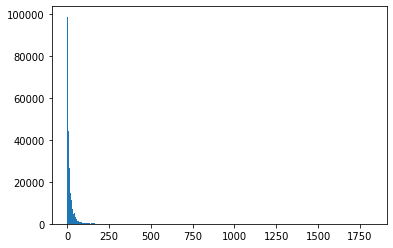

In [80]:
# Making histogram for no of words in sentences shows that most news sentences are under 150 words.
plt.hist([len(x) for x in X_tok], bins=500)
plt.show()

In [81]:
#Lets keep all sentences to 150, add padding to news with less than 150 words and truncating long ones
maxlen = 150 

#Making all news of size maxlen defined above, padding with 0 when needed
X_tok = pad_sequences(X_tok, maxlen=maxlen)

In [82]:
# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1
vocab_size

132528

#### One-Hot vectors of Levels

In [83]:
#Encoding labels as one-hot vectors
y = final_dataset["Level"]

# encode class values as integers
encoder_level = LabelEncoder()
encoder_level.fit(y)
encoded_y = encoder_level.transform(y)
y.value_counts()

NONE         199189
VERY_HIGH     67150
HIGH          53358
MEDIUM        46879
LOW           28016
Name: Level, dtype: int64

In [84]:
labels_mapping = dict(zip(encoder_level.classes_,encoder_level.transform(encoder_level.classes_)))
labels_mapping

{'HIGH': 0, 'LOW': 1, 'MEDIUM': 2, 'NONE': 3, 'VERY_HIGH': 4}

In [85]:
print(encoded_y)

[1 1 1 ... 3 3 3]


In [86]:
# convert integers to dummy variables (i.e. one hot encoded)
onehot_y = np_utils.to_categorical(encoded_y)

#### One-Hot vectors of Targets

In [87]:
#Encoding targets as one-hot vectors
targets = final_dataset["Target"]
encoder_target = LabelEncoder()
encoder_target.fit(targets)
encoded_targets = encoder_target.transform(targets)
targets.value_counts()

UNDEFINED            199191
USER                  97574
SINGLE_PERSON         36128
GROUP                 36083
EVERYONE              16603
USER_FAMILY            6466
AUTHOR_OF_COMMENT      2547
Name: Target, dtype: int64

In [88]:
onehot_targets = np_utils.to_categorical(encoded_targets)
onehot_targets

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [89]:
targets_mapping = dict(zip(encoder_target.classes_,encoder_target.transform(encoder_target.classes_)))
targets_mapping

{'AUTHOR_OF_COMMENT': 0,
 'EVERYONE': 1,
 'GROUP': 2,
 'SINGLE_PERSON': 3,
 'UNDEFINED': 4,
 'USER': 5,
 'USER_FAMILY': 6}

#### One-Hot vectors of Types

In [90]:
#Encoding targets as one-hot vectors
types = final_dataset["Type"]
encoder_types = LabelEncoder()
encoder_types.fit(types)
encoded_types = encoder_types.transform(types)
types.value_counts()

Neutral              200008
Insult               116947
Hate                  37293
Mockery               13950
Homophobia            12256
Sexual Harassment      4603
Troll                  3461
Threat                 2282
Racism                 2143
Moral Harassment       1583
Ads                      27
Useless                  18
Critics                  15
Misogyny                  6
Name: Type, dtype: int64

In [91]:
onehot_types = np_utils.to_categorical(encoded_types)
onehot_types

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [92]:
types_mapping = dict(zip(encoder_types.classes_,encoder_types.transform(encoder_types.classes_)))
types_mapping

{'Ads': 0,
 'Critics': 1,
 'Hate': 2,
 'Homophobia': 3,
 'Insult': 4,
 'Misogyny': 5,
 'Mockery': 6,
 'Moral Harassment': 7,
 'Neutral': 8,
 'Racism': 9,
 'Sexual Harassment': 10,
 'Threat': 11,
 'Troll': 12,
 'Useless': 13}

#### Keras tokenization of Emojis

In [93]:
"""
#Tokenizing EmojisToText with Keras -> Representing each word by a number
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_emojis = Tokenizer(lower=True)
tokenizer_emojis.fit_on_texts(final_dataset["Emoji_token"])

E_tok = tokenizer_emojis.texts_to_sequences(final_dataset["Emoji_token"])
"""

'\n#Tokenizing EmojisToText with Keras -> Representing each word by a number\nfrom tensorflow.keras.preprocessing.text import Tokenizer\n\ntokenizer_emojis = Tokenizer(lower=True)\ntokenizer_emojis.fit_on_texts(final_dataset["Emoji_token"])\n\nE_tok = tokenizer_emojis.texts_to_sequences(final_dataset["Emoji_token"])\n'

In [94]:
"""#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
emoji_index = tokenizer_emojis.word_index
for word, num in emoji_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        
"""

'#Lets check few word to numerical representation\n#Mapping is preserved in dictionary -> word_index property of instance\nemoji_index = tokenizer_emojis.word_index\nfor word, num in emoji_index.items():\n    print("{} -> {}".format(word, num))\n    if num == 10:\n        break        \n'

In [95]:
"""print(np.average([len(x) for x in E_tok]))"""

'print(np.average([len(x) for x in E_tok]))'

In [96]:
"""#Lets keep all emoji description to 50, add padding to short ones and truncating long ones
maxlen_emoji = 50

#Making all news of size maxlen defined above, padding with 0 when needed
E_tok = pad_sequences(E_tok, maxlen=maxlen_emoji)"""

'#Lets keep all emoji description to 50, add padding to short ones and truncating long ones\nmaxlen_emoji = 50\n\n#Making all news of size maxlen defined above, padding with 0 when needed\nE_tok = pad_sequences(E_tok, maxlen=maxlen_emoji)'

In [97]:
"""# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size increases by 1
emo_vocab_size = len(tokenizer_emojis.word_index) + 1"""

'# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.\n# Thus our vocab size increases by 1\nemo_vocab_size = len(tokenizer_emojis.word_index) + 1'

#### Dataset split

In [98]:
#Creating input and output sets
#X_train_tok, X_test_tok, E_train_tok, E_test_tok, X_train_targets, X_test_targets, y_train_tok, y_test_tok = train_test_split(X_tok, E_tok, onehot_targets, onehot_y, test_size = 0.2) 
X_train_tok, X_test_tok, X_train_targets, X_test_targets, X_train_class, X_test_class, X_train_types, X_test_types, y_train_tok, y_test_tok = train_test_split(X_tok, onehot_targets, final_dataset['Class'], onehot_types, onehot_y, test_size = 0.2, stratify = onehot_y)

In [99]:
#Creating class_weights dict for coping with imbalanced dataset
import collections, math

def create_class_weight(labels_dict,mu=0.6):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

# random labels_dict
labels_dict = collections.Counter(encoded_y)
print(labels_dict)

class_weights = create_class_weight(labels_dict)
print(class_weights)

Counter({3: 199189, 4: 67150, 0: 53358, 2: 46879, 1: 28016})
{1: 2.134250920378633, 2: 1.6194568819389028, 0: 1.4900027762765713, 4: 1.2600977729528826, 3: 1.0}


# Vectorization

In [100]:
EMBEDDING_DIM = 200

In [101]:
# Function to create weight matrix between word-index and vectors from gensim models
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try: 
          weight_matrix[i] = model[word]
        except:
          pass
    return weight_matrix

### Via Word2Vec

In [102]:
w2v_model = gensim.models.Word2Vec(sentences=final_dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [103]:
len(w2v_model.wv.vocab)

36605

In [104]:
w2v_model["merde"]

array([ 1.5694987 , -2.8035123 ,  0.61882097,  0.59240973, -1.7922435 ,
       -1.5749567 ,  0.68017095, -0.33605605, -2.7257795 , -2.3226666 ,
        0.9089815 ,  2.7529256 ,  1.0813727 , -2.7224557 ,  2.342935  ,
        0.2040241 ,  0.11019222, -1.436588  ,  3.3415225 ,  0.82127255,
       -1.3220769 ,  0.7670948 ,  1.2702721 , -0.2735578 , -2.6251626 ,
       -1.1406283 ,  2.010894  , -1.4171531 ,  2.5134344 , -2.960038  ,
       -0.03478711, -0.27337655,  0.04821605, -0.11083303, -0.7343947 ,
       -2.1958418 ,  2.2320976 ,  0.148103  ,  1.7206181 ,  0.85233563,
       -1.5554518 , -0.03822817, -0.81236535,  0.39254883,  1.0023336 ,
        1.0787337 , -1.7550824 , -1.2029011 ,  2.2465014 , -0.8162036 ,
       -0.47535974,  0.9377461 ,  0.17693663, -0.95695734,  0.47546834,
        1.6283958 , -2.1789901 ,  0.7623456 ,  1.0453247 ,  2.736361  ,
       -0.20334962, -2.1507955 , -1.9472568 ,  0.9196927 , -1.0435194 ,
       -2.1823967 , -0.11749376,  1.8648341 ,  0.35709795, -0.69

In [105]:
print(w2v_model.wv.most_similar("merde"))

[('merdes', 0.5401418805122375), ('daube', 0.5206794738769531), ('mrd', 0.5102776288986206), ('merd', 0.5024012327194214), ('vermine', 0.49046340584754944), ('bouse', 0.4656129479408264), ('marde', 0.4547578692436218), ('faute', 0.45284849405288696), ('racaille', 0.4348313808441162), ('m3rde', 0.4337153434753418)]


In [106]:
w2v_embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [107]:
w2v_model["kiko"]

array([-0.00261095,  0.05004504, -0.01225668,  0.06149428, -0.03471529,
       -0.03294529, -0.12205197, -0.01735243,  0.02609205, -0.04727412,
       -0.126534  ,  0.05146424,  0.07252588,  0.10256053,  0.03547869,
        0.02563904, -0.13830487, -0.06222481, -0.00431934, -0.07576594,
       -0.01109046, -0.04876032, -0.01104961,  0.0541286 ,  0.10404778,
       -0.11539351,  0.03855012,  0.03373434, -0.03861264, -0.01295265,
       -0.08360665,  0.07218335, -0.00430328,  0.01330107, -0.08103434,
        0.04864682,  0.01215082,  0.04110546, -0.0634735 ,  0.0050682 ,
       -0.08680385, -0.036264  , -0.01897772, -0.17051998,  0.02919878,
       -0.06385124,  0.14681019,  0.11111788,  0.00225177, -0.0637282 ,
       -0.05278291,  0.0174063 , -0.03034232,  0.07811918, -0.05671333,
        0.08779155, -0.10792789, -0.10100577,  0.03897907,  0.08028068,
        0.02154106,  0.09340935, -0.01087405,  0.01890234,  0.10367684,
       -0.05914449, -0.04774034,  0.07196482,  0.08639733, -0.09

In [108]:
print(w2v_model.wv.most_similar("kiko"))

[('coul', 0.8622430562973022), ('proxz', 0.8565542697906494), ('mendy', 0.854188859462738), ('kin', 0.85361647605896), ('nullllllllll', 0.8533563017845154), ('noam', 0.8528010249137878), ('frs', 0.83934485912323), ('lyonnet', 0.8380762338638306), ('bzr', 0.83603435754776), ('clacla', 0.8349850177764893)]


In [ ]:
#w2v_emojis = gensim.models.Word2Vec(sentences=final_dataset["Emoji_token"], size=EMBEDDING_DIM, window=5, min_count=5)

In [ ]:
#len(w2v_emojis.wv.vocab)

In [ ]:
#w2v_emoji_embedding_vectors = get_weight_matrix(w2v_emojis, emoji_index)

### Via FastText (Gensim)

In [236]:
fasttext_model = gensim.models.FastText(sentences=final_dataset["finalSentence"], size=EMBEDDING_DIM, window=5, min_count=5)

In [ ]:
len(fasttext_model.wv.vocab)

In [ ]:
fasttext_model.wv["merde"]

array([ 1.1284579 ,  0.6026093 ,  0.55194414, -1.4858775 , -1.8394794 ,
       -3.0810142 , -0.940217  , -1.6027595 , -1.5497886 , -0.85429865,
       -0.6348115 , -1.8178934 ,  2.1839948 , -1.6538231 , -0.85423   ,
       -1.5764794 ,  1.4149851 ,  1.0057323 , -0.36474034,  0.29080233,
       -0.21080719, -0.17950217, -0.45694226,  1.8594996 , -2.1465688 ,
        0.2735612 ,  0.3968396 , -0.62402505, -0.9700226 , -1.2724721 ,
        1.8486054 ,  0.15272905,  0.54489774, -0.37184393,  0.6777381 ,
        2.389091  , -0.8056522 ,  0.8209127 ,  0.25181684, -1.0788106 ,
        0.50884855, -1.0748245 , -1.5625927 ,  2.1265693 ,  0.769541  ,
        2.002416  ,  0.7465693 ,  0.2287906 ,  0.11381675,  0.21265097,
       -1.9339    , -0.12194537, -0.7238728 , -2.128207  , -1.4337852 ,
       -1.9397132 , -2.0834067 , -1.2747929 , -1.898521  ,  0.45629272,
       -1.0381802 ,  1.0910054 , -2.6330535 ,  1.1270115 ,  2.9112854 ,
       -0.17099997,  1.5804169 , -1.9675343 , -0.30740622, -3.94

In [ ]:
print(fasttext_model.wv.most_similar("merde"))

[('merdebfmmerde', 0.9710953235626221), ('dmerde', 0.9606221318244934), ('merdeee', 0.9603695273399353), ('bfmerde', 0.9471138715744019), ('merdeu', 0.9379007816314697), ('merdeeee', 0.9377528429031372), ('emerde', 0.9298129677772522), ('merddd', 0.9261928796768188), ('merd', 0.9223754405975342), ('démerde', 0.9182571172714233)]


In [ ]:
ft_embedding_vectors = get_weight_matrix(fasttext_model, word_index)

### Via FastText Pretrained vectors

In [ ]:
!pip install fasttext

#Recommended alternative, since few modules are missing in the PyPi package:
#!pip uninstall fasttext
#!git clone https://github.com/facebookresearch/fastText.git
#!cd fastText
#!pip install .

     |████████████████████████████████| 71kB 5.0MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3094870 sha256=382d9c3c620812490e28612c61ebea8939f9cf1af438a67b542e516239f1ff21
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
import fasttext.util
fasttext.util.download_model('fr', if_exists='ignore')
ft_pre_model = fasttext.load_model('cc.fr.300.bin')

In [ ]:
ft_pre_model.get_dimension()

300

In [ ]:
ft_pre_model.get_nearest_neighbors('merde')

NameError: ignored

In [ ]:
#Optional - reduce vectors dimensions
fasttext.util.reduce_model(ft_pre_model, 200)
ft_pre_model.get_dimension()

In [ ]:
ft_pre_embedding_vectors = get_weight_matrix(ft_pre_model, word_index)

# Level prediction

## Based on sentence only

### Via Perspective API

In [ ]:
"""
from googleapiclient import discovery
import json

API_KEY=''

service = discovery.build('commentanalyzer', 'v1alpha1', developerKey=API_KEY)


Labels = []
Predictions = []
Language = []
Fail = []

file1 = open('dataset_clean.txt', 'r')
Lines = file1.readlines()

last_time = time.time()
count = 0

for line in Lines:
  time.sleep(1)        

  elements = line.split(" ", 1)

  analyze_request = {
                'comment': { 'text': elements[1].strip() },
                'requestedAttributes': {'TOXICITY': {}}
              }

  try:
      response = service.comments().analyze(body=analyze_request).execute()
  except Exception as e:
      Fail.append(elements[1])
      print(elements[1])
      continue    

  Labels.append(elements[0])
  Language.append(json.dumps(response["languages"][0], indent=2))
  proba = json.dumps(response["attributeScores"]["TOXICITY"]["spanScores"][0]["score"]["value"], indent=2)
  if float(proba) <= 0.2:
      Predictions.append("NONE")
  elif float(proba) <= 0.4:
      Predictions.append("LOW")
  elif float(proba) <= 0.6:
      Predictions.append("MEDIUM")
  elif float(proba) <= 0.8:
      Predictions.append("HIGH")
  else:
      Predictions.append("VERY_HIGH")
  count += 1


with open('/content/drive/My Drive/CS224n_Project/Perspective_labels.txt'', 'w') as f:
    for item in Labels:
        f.write("%s," % item)

with open('/content/drive/My Drive/CS224n_Project/Perspective_preds.txt'', 'w') as f:
    for item in Predictions:
        f.write("%s," % item)

In [39]:
#Analysis of Toxicity scores obtained from Perspective API on part of the dataset

perspective = pd.DataFrame()

with open('/content/drive/My Drive/CS224n_Project/Perspective_labels.txt') as f:
  label_values = f.readlines()
  label_levels = label_values[0].split(",")

with open('/content/drive/My Drive/CS224n_Project/Perspective_preds.txt') as f:
  pred_values = f.readlines()
  pred_levels = pred_values[0].split(",")

perspective["Labels"] = label_levels
perspective["Predictions"] = pred_levels

perspective["Pred_Result"] = (perspective['Labels']==perspective['Predictions']).astype(int)
perspective['Sentences'] = pd.read_csv('/content/drive/My Drive/CS224n_Project/Perspective_sent.txt', sep="\n", header=None)

perspective

,Labels,Predictions,Pred_Result,Sentences
0,LOW,NONE,0,t pas bo
1,LOW,LOW,1,t es vilain
2,LOW,NONE,0,je te propose un d île je m abonne à ta chaine...
3,LOW,NONE,0,t un kiko mdr
4,LOW,MEDIUM,0,moi mdr t trop nul
...,...,...,...,...
99995,MEDIUM,HIGH,0,et après on s étonne d en voir qui font les pu...
99996,MEDIUM,MEDIUM,1,on dirait une parodie de campagne de green was...
99997,MEDIUM,VERY_HIGH,0,damien renaud tous des salopes de a à z
99998,MEDIUM,HIGH,0,surtout une bande de c


In [40]:
label_dict = {'NONE': 0, 'LOW': 1, 'MEDIUM': 2, 'HIGH': 3, 'VERY_HIGH': 4}

perspective['Label_num'] = perspective['Labels'].apply(lambda x: label_dict[x])
perspective['Pred_num'] = perspective['Predictions'].apply(lambda x: label_dict[x])
perspective.head()

,Labels,Predictions,Pred_Result,Sentences,Label_num,Pred_num
0,LOW,NONE,0,t pas bo,1,0
1,LOW,LOW,1,t es vilain,1,1
2,LOW,NONE,0,je te propose un d île je m abonne à ta chaine...,1,0
3,LOW,NONE,0,t un kiko mdr,1,0
4,LOW,MEDIUM,0,moi mdr t trop nul,1,2


In [43]:
print(classification_report(perspective["Label_num"], perspective["Pred_num"]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.23      0.20      0.21     14816
           2       0.26      0.14      0.18     24005
           3       0.26      0.18      0.22     27175
           4       0.45      0.46      0.45     34004

    accuracy                           0.27    100000
   macro avg       0.24      0.20      0.21    100000
weighted avg       0.32      0.27      0.29    100000



In [44]:
conf_matrix = confusion_matrix(perspective["Label_num"], perspective["Pred_num"])
print(conf_matrix)

[[    0     0     0     0     0]
 [ 3497  2919  2984  3239  2177]
 [ 5696  3510  3325  5301  6173]
 [ 4797  3325  3073  5025 10955]
 [ 6400  2768  3372  5934 15530]]


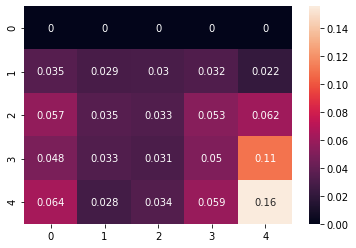

In [45]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [47]:
#Error analysis
perspective[perspective["Pred_Result"] == 0][:50]

,Labels,Predictions,Pred_Result,Sentences,Label_num,Pred_num
0,LOW,NONE,0,t pas bo,1,0
2,LOW,NONE,0,je te propose un d île je m abonne à ta chaine...,1,0
3,LOW,NONE,0,t un kiko mdr,1,0
4,LOW,MEDIUM,0,moi mdr t trop nul,1,2
6,LOW,VERY_HIGH,0,grosse merdes,1,4
7,LOW,MEDIUM,0,espèce de gamin,1,2
8,LOW,MEDIUM,0,c est quoi cette mode ou presque tout les yout...,1,2
9,LOW,HIGH,0,et il est au dessus des lois je fais des reuni...,1,3
10,LOW,NONE,0,vous êtes gênant,1,0
12,LOW,MEDIUM,0,frr c quoi sa car t radin je vais venir chez t...,1,2


In [49]:
#Averaging Perspective API prediction score to neighbour levels

perspective["Diff_score"] = perspective["Pred_num"] - perspective["Label_num"]
perspective["Diff_score"] = np.abs(perspective["Diff_score"])
perspective["Average_score"] = perspective["Diff_score"].apply(lambda x: 1 if x < 2 else 0)
perspective

,Labels,Predictions,Pred_Result,Sentences,Label_num,Pred_num,Diff_score,Average_score
0,LOW,NONE,0,t pas bo,1,0,1,1
1,LOW,LOW,1,t es vilain,1,1,0,1
2,LOW,NONE,0,je te propose un d île je m abonne à ta chaine...,1,0,1,1
3,LOW,NONE,0,t un kiko mdr,1,0,1,1
4,LOW,MEDIUM,0,moi mdr t trop nul,1,2,1,1
...,...,...,...,...,...,...,...,...
99995,MEDIUM,HIGH,0,et après on s étonne d en voir qui font les pu...,2,3,1,1
99996,MEDIUM,MEDIUM,1,on dirait une parodie de campagne de green was...,2,2,0,1
99997,MEDIUM,VERY_HIGH,0,damien renaud tous des salopes de a à z,2,4,2,0
99998,MEDIUM,HIGH,0,surtout une bande de c,2,3,1,1


In [50]:
perspective["Average_score"].value_counts()

1    62053
0    37947
Name: Average_score, dtype: int64

In [56]:
print('Perspective API average Accuracy = ', perspective[perspective["Average_score"] == 1].count() / len(perspective))

Perspective API average Accuracy =  Labels           0.62053
Predictions      0.62053
Pred_Result      0.62053
Sentences        0.62030
Label_num        0.62053
Pred_num         0.62053
Diff_score       0.62053
Average_score    0.62053
dtype: float64


### Via FastText

In [ ]:
import fasttext

In [ ]:
#Data preparation for fasttext format

X_train_ft, X_test_ft, y_train_fr, y_test_ft = train_test_split(dataset['cleanSentence'],  dataset['Level'], test_size = 0.2)

label_mapping = {'NONE': '__label__0',
                     'LOW': '__label__1',
                     'MEDIUM': '__label__2',
                     'HIGH': '__label__3',
                     'VERY_HIGH': '__label__4'}

with open('fasttext_train.txt', 'w') as f:
    for each_text, each_label in zip(X_train_ft, y_train_fr):
        each_label = label_mapping[each_label]
        f.writelines(f'{each_label} {each_text}\n')

with open('fasttext_test.txt', 'w') as f:
    for each_text, each_label in zip(X_test_ft, y_test_ft):
        each_label = label_mapping[each_label]
        f.writelines(f'{each_label} {each_text}\n')

In [ ]:
#Training
ft_model2 = fasttext.train_supervised('fasttext_train.txt')

#model = fasttext.train_supervised(input=train_fn,
#                                  pretrainedVectors=pretrainedvec_fn,
#                                  dim=200, 
#                                  wordNgrams=2, 
#                                  minCount=3, 
#                                  epoch=20, 
#                                  loss='ova')

In [ ]:
#print(ft_model2.words)
print(ft_model2.labels)

In [ ]:
#Evaluation
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*ft_model2.test('fasttext_test.txt'))

### Via Bi-LSTM

In [74]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [75]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 200)          26505600  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
dense (Dense)                (None, 200)               51400     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1005      
Total params: 26,894,901
Trainable params: 389,301
Non-trainable params: 26,505,600
_________________________________________________________________


In [76]:
#Resplitting data to apply SMOTE only to training set (not validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_tok, y_train_tok, stratify=y_train_tok)

In [77]:
#Data augmentation via SMOTE
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=42)
X_train_aug, y_train_aug  = over_sampling.fit_resample(X_train, y_train)

In [78]:
y_train.shape

(236754, 5)

In [79]:
y_train_aug.shape

(597085, 5)

In [80]:
y_train.sum(axis = 0)

array([ 32109.,  16859.,  28042., 119417.,  40327.], dtype=float32)

In [81]:
y_train_aug.sum(axis = 0)

array([119417, 119417, 119417, 119417, 119417])

In [82]:
pd.Series(y_train.argmax(axis = 1)).describe() 

count    236754.000000
mean          2.502606
std           1.243710
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
dtype: float64

In [83]:
pd.Series(y_train_aug.argmax(axis = 1)).describe() 

count    597085.000000
mean          2.000000
std           1.414215
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
dtype: float64

In [ ]:
#Train and Evaluate with SMOTE

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_aug, 
                                  y_train_aug,
                                  validation_data=(X_val, y_val),
                                  epochs=10, 
                                  batch_size = 1024,
                                  callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], 
                                  shuffle=True,
                                  verbose=1)

Epoch 1/10
584/584 [==============================] - 640s 1s/step - loss: 1.2047 - acc: 0.4998 - val_loss: 0.6945 - val_acc: 0.7715
Epoch 2/10
584/584 [==============================] - 635s 1s/step - loss: 0.8332 - acc: 0.6674 - val_loss: 0.6325 - val_acc: 0.7974
Epoch 3/10
584/584 [==============================] - ETA: 0s - loss: 0.7214 - acc: 0.7115

In [ ]:
#Standard Train & Evaluate

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, y_train_tok, validation_split=0.2, epochs=10, batch_size = 1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/10
494/494 [==============================] - 542s 1s/step - loss: 0.8064 - acc: 0.7124 - val_loss: 0.6712 - val_acc: 0.7609
Epoch 2/10
494/494 [==============================] - 538s 1s/step - loss: 0.6329 - acc: 0.7770 - val_loss: 0.5791 - val_acc: 0.7979
Epoch 3/10
494/494 [==============================] - 547s 1s/step - loss: 0.5584 - acc: 0.8053 - val_loss: 0.5178 - val_acc: 0.8249
Epoch 4/10
494/494 [==============================] - 549s 1s/step - loss: 0.5098 - acc: 0.8238 - val_loss: 0.4765 - val_acc: 0.8397
Epoch 5/10
494/494 [==============================] - 549s 1s/step - loss: 0.4711 - acc: 0.8390 - val_loss: 0.4493 - val_acc: 0.8530
Epoch 6/10
494/494 [==============================] - 554s 1s/step - loss: 0.4425 - acc: 0.8495 - val_loss: 0.4279 - val_acc: 0.8623
Epoch 7/10
494/494 [==============================] - 556s 1s/step - loss: 0.4207 - acc: 0.8577 - val_loss: 0.4180 - val_acc: 0.8667
Epoch 8/10
494/494 [==============================] - 560s 1s/step - 

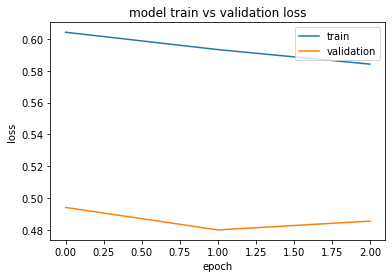

In [197]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [198]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [199]:
print(classification_report(y_test_tok, lstm_pred))

              precision    recall  f1-score   support

           0       0.83      0.70      0.76     10572
           1       0.82      0.83      0.82      5637
           2       0.81      0.71      0.75      9300
           3       0.94      0.90      0.92     39896
           4       0.87      0.79      0.83     13514

   micro avg       0.89      0.82      0.86     78919
   macro avg       0.85      0.78      0.82     78919
weighted avg       0.89      0.82      0.85     78919
 samples avg       0.82      0.82      0.82     78919



In [200]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

[[ 8530   248   419   743   632]
 [  453  4666   252   158   108]
 [ 1264   234  6561   683   558]
 [ 2957   372   482 35817   268]
 [ 1478   155   426   841 10614]]


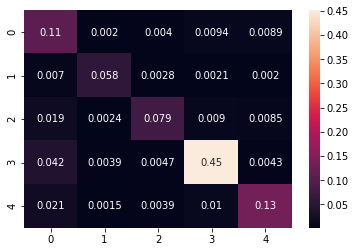

In [195]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via 2 Bi-LSTM with Emojis

In [ ]:
input1 = Input(shape=(maxlen,))
embed1 = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False)(input1)
bdlstm1 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed1)
dense1 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm1)

input2 = Input(shape=(maxlen_emoji,))
embed2 = Embedding(emo_vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_emoji_embedding_vectors], input_length=maxlen_emoji, trainable=False)(input2)
bdlstm2 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed2)
dense2 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
bilstm_model = keras.Model(inputs = [input1, input2], outputs = out)
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
bilstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 200)     26521600    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 200)      229600      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

bilstm_history = bilstm_model.fit([X_train_tok, E_train_tok], y_train_tok, validation_split=0.2, epochs=6, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 276s 1ms/sample - loss: 0.8221 - acc: 0.7039 - val_loss: 0.6587 - val_acc: 0.7647
Epoch 2/6
252538/252538 [==============================] - 271s 1ms/sample - loss: 0.6326 - acc: 0.7739 - val_loss: 0.5665 - val_acc: 0.8010
Epoch 3/6
252538/252538 [==============================] - 272s 1ms/sample - loss: 0.5594 - acc: 0.8011 - val_loss: 0.5107 - val_acc: 0.8222
Epoch 4/6
252538/252538 [==============================] - 271s 1ms/sample - loss: 0.5100 - acc: 0.8198 - val_loss: 0.4696 - val_acc: 0.8400
Epoch 5/6
252538/252538 [==============================] - 268s 1ms/sample - loss: 0.4725 - acc: 0.8342 - val_loss: 0.4429 - val_acc: 0.8504
Epoch 6/6
252538/252538 [==============================] - 269s 1ms/sample - loss: 0.4435 - acc: 0.8459 - val_loss: 0.4231 - val_acc: 0.8593


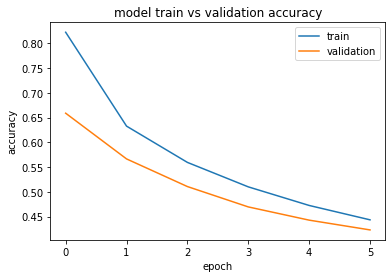

In [ ]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
bilstm_pred = (bilstm_model.predict([X_test_tok, E_test_tok]) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, bilstm_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), bilstm_pred.argmax(axis=1))
print(conf_matrix)

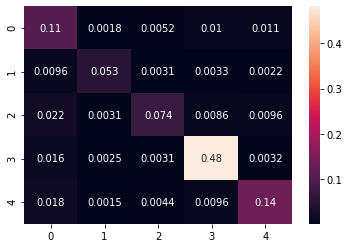

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via Transformer

https://keras.io/examples/nlp/text_classification_with_transformer/

In [93]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

     |████████████████████████████████| 432.2MB 41kB/s 
     |████████████████████████████████| 6.0MB 41.6MB/s 
     |████████████████████████████████| 471kB 57.9MB/s 
     |████████████████████████████████| 4.0MB 47.5MB/s 
     |████████████████████████████████| 4.0MB 48.7MB/s 
     |████████████████████████████████| 3.9MB 49.0MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10

In [94]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [95]:
#Create classifier model using transformer layer

embed_dim = 64  # Embedding size for each token (vs 32 ?)
num_heads = 2  # Number of attention heads 
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(embed_dim, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation="softmax")(x)

transfo_model = keras.Model(inputs=inputs, outputs=outputs)
transfo_model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [165]:
#Resplitting data to apply SMOTE only to training set (not validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_tok, y_train_tok, stratify=y_train_tok)

In [166]:
#Data augmentation via SMOTE
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=42)
X_train_aug, y_train_aug  = over_sampling.fit_resample(X_train, y_train)

In [167]:
y_train.shape

(236754, 5)

In [168]:
y_train_aug.shape

(597345, 5)

In [169]:
y_train.sum(axis = 0)

array([ 32090.,  16784.,  28184., 119469.,  40227.], dtype=float32)

In [170]:
y_train_aug.sum(axis = 0)

array([119469, 119469, 119469, 119469, 119469])

In [171]:
pd.Series(y_train.argmax(axis = 1)).describe() 

count    236754.000000
mean          2.502458
std           1.242922
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           4.000000
dtype: float64

In [172]:
pd.Series(y_train_aug.argmax(axis = 1)).describe() 

count    597345.000000
mean          2.000000
std           1.414215
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           4.000000
dtype: float64

In [173]:
#Train and Evaluate with SMOTE

early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_history = transfo_model.fit(X_train_aug, 
                                  y_train_aug,
                                  validation_data=(X_val, y_val),
                                  epochs=6, 
                                  batch_size = 1024,
                                  callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], 
                                  shuffle=True,
                                  verbose=1)

Epoch 1/6
584/584 [==============================] - 107s 182ms/step - loss: 0.7576 - accuracy: 0.7424 - val_loss: 0.4894 - val_accuracy: 0.8819
Epoch 2/6
584/584 [==============================] - 106s 181ms/step - loss: 0.6421 - accuracy: 0.7667 - val_loss: 0.4862 - val_accuracy: 0.8770
Epoch 3/6
584/584 [==============================] - 106s 181ms/step - loss: 0.5789 - accuracy: 0.7824 - val_loss: 0.4908 - val_accuracy: 0.8713


In [98]:
#Train and Evaluate with class weights
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_history = transfo_model.fit(
    X_train_tok, y_train_tok, validation_split=0.2, batch_size=1024, epochs=6 , \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1, class_weight = class_weights)

Epoch 1/6
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
247/247 [==============================] - ETA: 0s - loss: 1.8521 - accuracy: 0.5003WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f1e0578e7a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

In [104]:
#Standard Train and Evaluate
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_history = transfo_model.fit(
    X_train_tok, y_train_tok, validation_split=0.2, batch_size=1024, epochs=6 , \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
247/247 [==============================] - 46s 185ms/step - loss: 0.2423 - accuracy: 0.9210 - val_loss: 0.4658 - val_accuracy: 0.8719
Epoch 2/6
247/247 [==============================] - 46s 185ms/step - loss: 0.2216 - accuracy: 0.9272 - val_loss: 0.4901 - val_accuracy: 0.8700


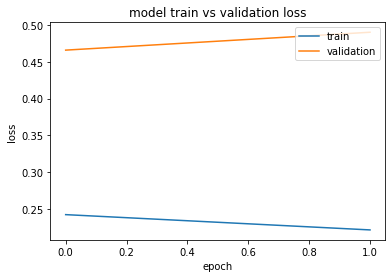

In [105]:
plt.plot(transfo_history.history['loss'])
plt.plot(transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [106]:
transfo_pred = (transfo_model.predict(X_test_tok) >= 0.5).astype("int")

In [107]:
print(classification_report(y_test_tok, transfo_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.78     10596
           1       0.82      0.82      0.82      5665
           2       0.82      0.71      0.76      9306
           3       0.96      0.93      0.94     39953
           4       0.82      0.83      0.82     13399

   micro avg       0.89      0.86      0.87     78919
   macro avg       0.84      0.81      0.83     78919
weighted avg       0.89      0.86      0.87     78919
 samples avg       0.86      0.86      0.86     78919



In [102]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9019   257   251   328   741]
 [  523  4718   222    88   114]
 [ 1626   334  6057   480   809]
 [ 1766   440   446 36584   717]
 [ 1554   244   195   511 10895]]


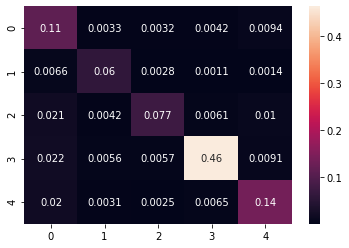

In [103]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

### Via CamemBERT

==> https://colab.sandbox.google.com/drive/1KgWs_sYNEL_ZnnZ_p7eTSevVb5xXx1Hu?usp=sharing#scrollTo=ELf3ehrNxY3k

In [74]:
!pip install transformers==3.5.1
!pip install sentencepiece
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 6
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text = dataset['cleanSentence'].to_list()
labels = list(encoded_y)

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

     |████████████████████████████████| 1.3MB 6.3MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 2.9MB 27.1MB/s 
     |████████████████████████████████| 1.1MB 35.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aeb2530dd28b18194070acc056e8d9a30cd7c8a88ff70590739bf25521531ddb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


ImportError: ignored

In [ ]:
def preprocess(raw_text, labels=None):
    encoded_batch = cam_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                pad_to_max_length=True,
                                                max_length=MAX_LEN,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if labels:
        labels = torch.tensor(labels)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Split train-validation-test
train_inputs, test_inputs, train_labels, test_labels = train_test_split(text, labels,
                                                            random_state=42, test_size=0.2)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels,
                                                            random_state=42, test_size=0.2)

In [ ]:
train_input_ids, train_attention_mask, train_labels = preprocess(train_inputs, train_labels)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_labels)

val_input_ids, val_attention_mask, validation_labels = preprocess(validation_inputs, validation_labels)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_labels)

test_input_ids, test_attention_mask, test_labels = preprocess(test_inputs, test_labels)
# Combine the validation inputs into a TensorDataset
test_dataset = TensorDataset(
    test_input_ids,
    test_attention_mask,
    test_labels)

In [ ]:
# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("Bert_S_pred_Level.pt")
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Unable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 5)

model.to(device) 

Unable to load trained model.
[Errno 2] No such file or directory: 'Bert.pt'


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
#Training parameters
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

In [ ]:
# Training & Validation
for epoch in range(0, epochs):
  print("")
  print(f'########## Epoch {epoch+1} / {epochs} ##########')
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t0

        # Report progress
        print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
    #
    # 'batch' contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: skills 
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)

    # Clear any previously calculated gradients before performing a backward pass
    model.zero_grad()        

    # Perform a forward pass (evaluate the model on this training batch)
    # the loss (because we provided skills) and the "logits"--the model
    # outputs prior to activation
    loss, logits = model(input_id, 
                          token_type_ids=None, 
                          attention_mask=attention_mask, 
                          labels=label)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. 'loss' is a Tensor containing a
    # single value; the '.item()' function just returns the Python value 
    # from the tensor
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)   

  if epoch > 0:
      if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
          # i.e. If there is not improvement
          consecutive_epochs_with_no_improve += 1
      else:
          # If there is improvement
          consecutive_epochs_with_no_improve = 0
          print("Model saved!")
          torch.save(model.state_dict(), "Bert.pt")

  # Measure how long this epoch took
  training_time = time.time() - t0

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
      }
  )

  print("epoch: {} \n".format(epoch + 1), file=outfile)
  print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
  print("Training Time: {} \n".format(training_time), file=outfile)

  if consecutive_epochs_with_no_improve == 2:
      print("Stop training : The loss has not changed since 2 epochs!")
      break


  # Tracking variables for validation
  eval_loss, eval_accuracy = 0, 0
  batch_count = 0

  t1 = time.time()
  # Validation of the model
  model.eval()
  print('Evaluation...')

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      elapsed = time.time() - t1
      print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
      #
      # 'batch' contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: skills 
      input_id = batch[0].to(device)
      attention_mask = batch[1].to(device)
      label = batch[2].to(device)

      with torch.no_grad():
      # Forward pass, calculate logit predictions
          outputs =  model(input_id, token_type_ids=None, 
                            attention_mask=attention_mask,
                            labels=label)
          loss, logits = outputs[:2]

      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. 'loss' is a Tensor containing a
      # single value; the '.item()' function just returns the Python value 
      # from the tensor
      eval_loss += loss.item()

      # Move logits and labels to CPU if GPU is used
      logits = logits.detach().cpu().numpy()
      label_ids = label.to('cpu').numpy()
      predictions = np.argmax(logits, axis=1).flatten()

      tmp_eval_accuracy = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      if batch_count == 0:
          global_predictions = predictions
      else:
          global_predictions = np.append(global_predictions,predictions)
      batch_count += 1


  avg_validation_loss = eval_loss / len(validation_dataloader)   


  # Measure how long this epoch took
  validation_time = time.time() - t1

  print("")
  print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
  print("  Validation took: {:}".format(validation_time))
  print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
  # Calculate the average loss over all of the batches

  # Record all statistics from this epoch.
  validation_stats.append(
      {
          'Training Loss': avg_validation_loss,
          'Training Time': validation_time,
      }
  )

  print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
  print("Validation Time: {} \n".format(validation_time), file=outfile)
        
        
#with open('Bert_Metrics.json', 'w+') as outfile:
#    json.dump(training_stats, outfile)

#torch.save(model.state_dict(), "Bert.pt")
#print("Final Model saved!")


########## Epoch 1 / 6 ##########
Training...


AttributeError: ignored

In [ ]:
#Evaluating on dev set
print("Test mode: \n")

t2 = time.time()
model.eval()
batch_count = 0
test_loss, test_accuracy = 0, 0

for batch in test_dataloader:
        
    # Progress update every 40 batches.
    if batch_count % 40 == 0 and not batch_count == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t2

        # Report progress
        print(f'  Batch {batch_count}  of  {len(test_dataloader)}    Elapsed: {format_time(elapsed)}.')
        
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)

    with torch.no_grad():
    # Forward pass, calculate logit predictions
        outputs =  model(input_id, token_type_ids=None, 
                              attention_mask=attention_mask,
                              labels=label)
        loss, logits = outputs[:2]

    test_loss += loss.item()

    # Move logits and labels to CPU if GPU is used
    logits = logits.detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    predictions = np.argmax(logits, axis=1).flatten()

    tmp_test_accuracy = flat_accuracy(logits, label_ids)

    test_accuracy += tmp_test_accuracy
    if batch_count == 0:
        global_predictions = predictions
    else:
        global_predictions = np.append(global_predictions,predictions)
    batch_count += 1


In [ ]:
avg_test_loss = test_loss / len(validation_dataloader)   

test_time = time.time() - t2

global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(test_labels, global_preds, zero_division=0)

confusion_matrix = metrics.confusion_matrix(test_labels, global_preds)

print("")
print("  Average test loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))
print("  Test Accuracy: {}".format(test_accuracy/batch_count))
print("")
print("Report on test set: {} \n".format(report))
print("Confusion Matrix on test set: \n{} \n".format(confusion_matrix))

In [ ]:
sns.heatmap(confusion_matrix, annot=True)

## Based on sentence + target

### Via Bi-LSTM

In [132]:
input1 = Input(shape=(maxlen,))
embed1 = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False)(input1)
bdlstm1 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed1)
dense1 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm1)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
bilstm_model = keras.Model(inputs = [input1, input2], outputs = out)
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [133]:
bilstm_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 150, 200)     26505600    input_10[0][0]                   
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) (None, 256)          336896      embedding_11[0][0]               
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 7)]          0                                            
____________________________________________________________________________________________

In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

bilstm_history = bilstm_model.fit([X_train_tok, X_train_targets], y_train_tok, validation_split=0.2, epochs=6, batch_size = 1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 228s 904us/sample - loss: 0.5586 - acc: 0.7743 - val_loss: 0.4240 - val_acc: 0.8254
Epoch 2/6
252538/252538 [==============================] - 227s 897us/sample - loss: 0.3927 - acc: 0.8397 - val_loss: 0.3475 - val_acc: 0.8637
Epoch 3/6
252538/252538 [==============================] - 225s 891us/sample - loss: 0.3382 - acc: 0.8647 - val_loss: 0.3071 - val_acc: 0.8826
Epoch 4/6
252538/252538 [==============================] - 222s 880us/sample - loss: 0.3012 - acc: 0.8809 - val_loss: 0.2740 - val_acc: 0.8986
Epoch 5/6
252538/252538 [==============================] - 224s 887us/sample - loss: 0.2745 - acc: 0.8921 - val_loss: 0.2596 - val_acc: 0.9036
Epoch 6/6
252538/252538 [==============================] - 218s 864us/sample - loss: 0.2556 - acc: 0.9003 - val_loss: 0.2484 - val_acc: 0.9091


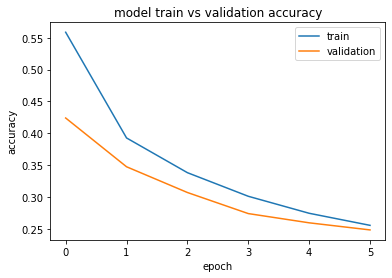

In [ ]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
bilstm_pred = (bilstm_model.predict([X_test_tok, X_test_targets]) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, bilstm_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     10828
           1       0.94      0.81      0.87      5610
           2       0.82      0.73      0.77      9296
           3       1.00      1.00      1.00     39709
           4       0.86      0.84      0.85     13476

   micro avg       0.93      0.89      0.91     78919
   macro avg       0.89      0.83      0.86     78919
weighted avg       0.93      0.89      0.91     78919
 samples avg       0.89      0.89      0.89     78919



In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), bilstm_pred.argmax(axis=1))
print(conf_matrix)

[[ 9230    98   620     0   880]
 [  568  4535   333     0   174]
 [ 1592   123  6756     2   823]
 [    3     0     1 39705     0]
 [ 1438    83   573     0 11382]]


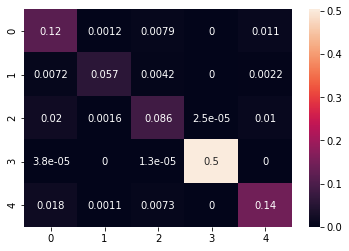

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via Transformer

In [ ]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

input1 = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(input1)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(EMBEDDING_DIM, activation="relu")(x)
dense1 = layers.Dropout(0.1)(x)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
targ_transfo_model = keras.Model(inputs = [input1, input2], outputs = out)
targ_transfo_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
targ_transfo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 150, 200)     26521600    input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 256)          336896      embedding_3[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 7)]          0                                            
____________________________________________________________________________________________

In [ ]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

targ_transfo_history = targ_transfo_model.fit([X_train_tok, X_train_targets], y_train_tok, validation_split=0.2, epochs=6, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 252538 samples, validate on 63135 samples
Epoch 1/6
252538/252538 [==============================] - 228s 904us/sample - loss: 0.5586 - acc: 0.7743 - val_loss: 0.4240 - val_acc: 0.8254
Epoch 2/6
252538/252538 [==============================] - 227s 897us/sample - loss: 0.3927 - acc: 0.8397 - val_loss: 0.3475 - val_acc: 0.8637
Epoch 3/6
252538/252538 [==============================] - 225s 891us/sample - loss: 0.3382 - acc: 0.8647 - val_loss: 0.3071 - val_acc: 0.8826
Epoch 4/6
252538/252538 [==============================] - 222s 880us/sample - loss: 0.3012 - acc: 0.8809 - val_loss: 0.2740 - val_acc: 0.8986
Epoch 5/6
252538/252538 [==============================] - 224s 887us/sample - loss: 0.2745 - acc: 0.8921 - val_loss: 0.2596 - val_acc: 0.9036
Epoch 6/6
252538/252538 [==============================] - 218s 864us/sample - loss: 0.2556 - acc: 0.9003 - val_loss: 0.2484 - val_acc: 0.9091


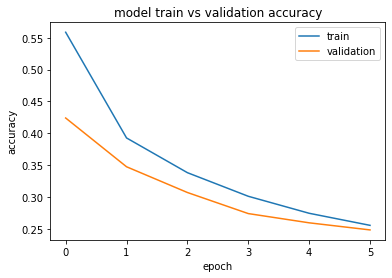

In [ ]:
plt.plot(targ_transfo_history.history['loss'])
plt.plot(targ_transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
targ_transfo_pred = (targ_transfo_model.predict([X_test_tok, X_test_targets]) >= 0.5).astype("int")

In [ ]:
print(classification_report(y_test_tok, targ_transfo_pred))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79     10828
           1       0.94      0.81      0.87      5610
           2       0.82      0.73      0.77      9296
           3       1.00      1.00      1.00     39709
           4       0.86      0.84      0.85     13476

   micro avg       0.93      0.89      0.91     78919
   macro avg       0.89      0.83      0.86     78919
weighted avg       0.93      0.89      0.91     78919
 samples avg       0.89      0.89      0.89     78919



In [ ]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), targ_transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9230    98   620     0   880]
 [  568  4535   333     0   174]
 [ 1592   123  6756     2   823]
 [    3     0     1 39705     0]
 [ 1438    83   573     0 11382]]


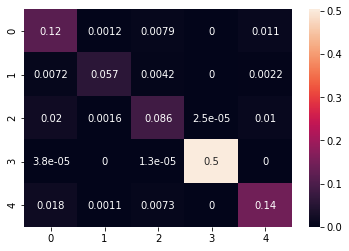

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

### Via CamemBERT

In [74]:
!pip install transformers==3.5.1
!pip install sentencepiece
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertModel, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 6
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text = dataset['cleanSentence'].to_list()
labels = list(encoded_y)
targets = onehot_targets

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

ModuleNotFoundError: ignored

In [ ]:
def preprocess(raw_text, targets, labels):
    encoded_batch = cam_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                pad_to_max_length=True,
                                                max_length=MAX_LEN,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    targets = torch.tensor(targets, dtype=torch.float)
    labels = torch.tensor(labels, dtype=torch.long)
    return encoded_batch['input_ids'], encoded_batch['attention_mask'], targets, labels


# Split train-validation
train_inputs, test_inputs, train_targets, test_targets, train_labels, test_labels = train_test_split(text, targets, labels,
                                                            random_state=42, test_size=0.2, stratify=labels)

train_inputs, validation_inputs, train_targets, validation_targets, train_labels, validation_labels = train_test_split(train_inputs, train_targets, train_labels,
                                                            random_state=42, test_size=0.2, stratify=train_labels)


train_input_ids, train_attention_mask, train_targets, train_labels = preprocess(train_inputs, train_targets, train_labels)

#Data augmentation via SMOTE
#from imblearn.over_sampling import SMOTE
#over_sampling = SMOTE(random_state=42)
#train_inputs_aug, train_labels_aug  = over_sampling.fit_resample(train_input_ids, train_labels)
#train_masks_aug, _  = over_sampling.fit_resample(train_attention_mask, train_labels)

#train_labels_aug = torch.tensor(train_labels_aug)
#validation_labels = torch.tensor(validation_labels)

# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_targets,
    train_labels)

#train_dataset = TensorDataset(
#    train_inputs_aug,
#    train_masks_aug,
#    train_labels_aug)

val_input_ids, val_attention_mask, validation_targets, validation_labels = preprocess(validation_inputs, validation_targets, validation_labels)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_targets,
    validation_labels)

test_input_ids, test_attention_mask, test_targets, test_labels = preprocess(test_inputs, test_targets, test_labels)
# Combine the validation inputs into a TensorDataset
test_dataset = TensorDataset(
    test_input_ids,
    test_attention_mask,
    test_targets,
    test_labels)

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

In [ ]:
class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        try:
            state_dict = torch.load("Bert_ST_Pred_Level.pt")
            print("Loading trained model...")
            self.bert = CamembertModel.from_pretrained(
            'camembert-base',
            state_dict=state_dict)
            print("Trained model loaded!")
        except Exception as e:
            print("Unable to load trained model.")
            print(e)
            self.bert = CamembertModel.from_pretrained(
                'camembert-base',
                num_labels = 5) 
        self.linear1 = nn.Linear(batch_size*768, 768)
        self.linear2 = nn.Linear(7, 768)
        self.linear3 = nn.Linear(2*768, 5)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        self.soft = nn.Softmax(dim=-1)

    def forward(self, input_id, attention_mask, targets):
        sequence_output = self.bert(
               input_id, 
               attention_mask=attention_mask)
        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        cls_embedding = sequence_output[0][:, 0, :]
#        linear1_output = self.linear1(cls_embedding)
#        relu1_output = self.relu(linear1_output)

        linear2_output = self.linear2(targets) 
        relu2_output = self.relu(linear2_output)

        concat_output = torch.cat((cls_embedding, relu2_output),1)
        final_output = self.linear3(concat_output)
        output = self.soft(final_output)

        return final_output

criterion = nn.CrossEntropyLoss()
model = CustomBERTModel()
model.to(device) 

In [ ]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0


In [ ]:
# Training & Validation
for epoch in range(0, epochs):
  print("")
  print(f'########## Epoch {epoch+1} / {epochs} ##########')
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t0

        # Report progress
        print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
    #
    # 'batch' contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: skills 
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    targets = batch[2].to(device)
    label = batch[3].to(device)

    # Clear any previously calculated gradients before performing a backward pass
    model.zero_grad()        

    # Perform a forward pass (evaluate the model on this training batch)
    # the loss (because we provided skills) and the "logits"--the model
    # outputs prior to activation
    logits = model(input_id, 
    #                     token_type_ids=None, 
                          attention_mask=attention_mask,
                          targets = targets)
    
    loss = criterion(logits, label)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. 'loss' is a Tensor containing a
    # single value; the '.item()' function just returns the Python value 
    # from the tensor
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)   

  if epoch > 0:
      if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
          # i.e. If there is not improvement
          consecutive_epochs_with_no_improve += 1
      else:
          # If there is improvement
          consecutive_epochs_with_no_improve = 0
          print("Model saved!")
          torch.save(model.state_dict(), "Bert.pt")

  # Measure how long this epoch took
  training_time = time.time() - t0

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
      }
  )

  print("epoch: {} \n".format(epoch + 1), file=outfile)
  print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
  print("Training Time: {} \n".format(training_time), file=outfile)

  if consecutive_epochs_with_no_improve == 2:
      print("Stop training : The loss has not changed since 2 epochs!")
      break


  # Tracking variables for validation
  eval_loss, eval_accuracy = 0, 0
  batch_count = 0

  t1 = time.time()
  # Validation of the model
  model.eval()
  print('Evaluation...')

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      elapsed = time.time() - t1
      print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
      #
      # 'batch' contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: skills 
      input_id = batch[0].to(device)
      attention_mask = batch[1].to(device)
      targets = batch[2].to(device)
      label = batch[3].to(device)

      with torch.no_grad():
      # Forward pass, calculate logit predictions
          logits =  model(input_id, 
      #                     token_type_ids=None, 
                            attention_mask=attention_mask,
                            targets = targets)
          loss = criterion(logits, label)

      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. 'loss' is a Tensor containing a
      # single value; the '.item()' function just returns the Python value 
      # from the tensor
      eval_loss += loss.item()

      # Move logits and labels to CPU if GPU is used
      logits = logits.detach().cpu().numpy()
      label_ids = label.to('cpu').numpy()
      predictions = np.argmax(logits, axis=1).flatten()

      tmp_eval_accuracy = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      if batch_count == 0:
          global_predictions = predictions
      else:
          global_predictions = np.append(global_predictions,predictions)
      batch_count += 1


  avg_validation_loss = eval_loss / len(validation_dataloader)   


  # Measure how long this epoch took
  validation_time = time.time() - t1

  print("")
  print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
  print("  Validation took: {:}".format(validation_time))
  print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
  # Calculate the average loss over all of the batches

  # Record all statistics from this epoch.
  validation_stats.append(
      {
          'Training Loss': avg_validation_loss,
          'Training Time': validation_time,
      }
  )

  print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
  print("Validation Time: {} \n".format(validation_time), file=outfile)
        
        
#with open('Bert_Metrics.json', 'w+') as outfile:
#    json.dump(training_stats, outfile)

#torch.save(model.state_dict(), "Bert.pt")
#print("Final Model saved!")

In [ ]:
#Evaluating on dev set
print("Test mode: \n")

t2 = time.time()
model.eval()
batch_count = 0
test_loss, test_accuracy = 0, 0

for batch in test_dataloader:
        
    # Progress update every 40 batches.
    if batch_count % 40 == 0 and not batch_count == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t2

        # Report progress
        print(f'  Batch {batch_count}  of  {len(test_dataloader)}    Elapsed: {format_time(elapsed)}.')
        
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    targets = batch[2].to(device)
    label = batch[2].to(device)

    with torch.no_grad():
    # Forward pass, calculate logit predictions
        logits =  model(input_id, token_type_ids=None, 
                              attention_mask=attention_mask,
                              targets=targets)
        loss = criterion(logits, label)

    test_loss += loss.item()

    # Move logits and labels to CPU if GPU is used
    logits = logits.detach().cpu().numpy()
    label_ids = label.to('cpu').numpy()
    predictions = np.argmax(logits, axis=1).flatten()

    tmp_test_accuracy = flat_accuracy(logits, label_ids)

    test_accuracy += tmp_test_accuracy
    if batch_count == 0:
        global_predictions = predictions
    else:
        global_predictions = np.append(global_predictions,predictions)
    batch_count += 1


In [ ]:
avg_test_loss = test_loss / len(validation_dataloader)   

test_time = time.time() - t2

global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(test_labels, global_preds, zero_division=0)

confusion_matrix = metrics.confusion_matrix(test_labels, global_preds)

print("")
print("  Average test loss: {0:.2f}".format(avg_test_loss))
print("  Test took: {:}".format(test_time))
print("  Test Accuracy: {}".format(test_accuracy/batch_count))
print("")
print("Report on test set: {} \n".format(report))
print("Confusion Matrix on test set: \n{} \n".format(confusion_matrix))

In [ ]:
sns.heatmap(confusion_matrix, annot=True)

## Based on sentence + type

#### Via Bi-LSTM

In [134]:
input1 = Input(shape=(maxlen,))
embed1 = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False)(input1)
bdlstm1 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed1)
dense1 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm1)

input2 = Input(shape=(14,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(5, activation='softmax')(dense)
bilstm_model = keras.Model(inputs = [input1, input2], outputs = out)
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [135]:
bilstm_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 150, 200)     26505600    input_12[0][0]                   
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 256)          336896      embedding_12[0][0]               
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 14)]         0                                            
____________________________________________________________________________________________

In [136]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

bilstm_history = bilstm_model.fit([X_train_tok, X_train_types], y_train_tok, validation_split=0.2, epochs=6, batch_size = 1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
247/247 [==============================] - 264s 1s/step - loss: 0.8740 - acc: 0.6624 - val_loss: 0.4467 - val_acc: 0.8198
Epoch 2/6
247/247 [==============================] - 254s 1s/step - loss: 0.4364 - acc: 0.8267 - val_loss: 0.3800 - val_acc: 0.8523
Epoch 3/6
247/247 [==============================] - 250s 1s/step - loss: 0.3715 - acc: 0.8562 - val_loss: 0.3362 - val_acc: 0.8717
Epoch 4/6
247/247 [==============================] - 252s 1s/step - loss: 0.3273 - acc: 0.8752 - val_loss: 0.3037 - val_acc: 0.8869
Epoch 5/6
247/247 [==============================] - 254s 1s/step - loss: 0.2917 - acc: 0.8901 - val_loss: 0.2797 - val_acc: 0.8994
Epoch 6/6
247/247 [==============================] - 248s 1s/step - loss: 0.2679 - acc: 0.9004 - val_loss: 0.2684 - val_acc: 0.9045


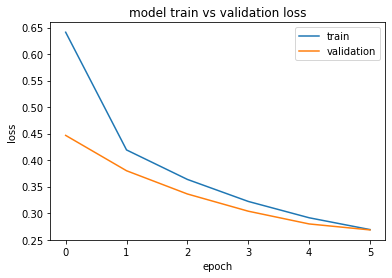

In [137]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [138]:
bilstm_pred = (bilstm_model.predict([X_test_tok, X_test_types]) >= 0.5).astype("int")

In [139]:
print(classification_report(y_test_tok, bilstm_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10666
           1       0.91      0.77      0.84      5598
           2       0.83      0.70      0.76      9441
           3       1.00      1.00      1.00     39828
           4       0.88      0.83      0.85     13386

   micro avg       0.93      0.89      0.91     78919
   macro avg       0.88      0.82      0.85     78919
weighted avg       0.92      0.89      0.90     78919
 samples avg       0.89      0.89      0.89     78919



In [140]:
conf_matrix = confusion_matrix(y_test_tok.argmax(axis=1), bilstm_pred.argmax(axis=1))
print(conf_matrix)

[[ 9220   173   516    53   704]
 [  784  4310   324    30   150]
 [ 1987   124  6578    40   712]
 [    2     0     1 39824     1]
 [ 1623   118   463    42 11140]]


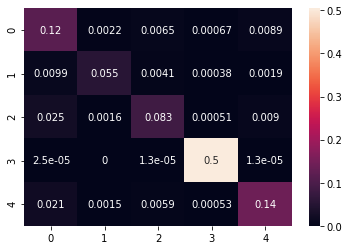

In [141]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

# Target prediction

### By training a classifier based on current "Target" label

#### Via Bi-LSTM

In [114]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#Bi-LSTM
#lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
lstm_model.add(Flatten())
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(7, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [115]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 200)          26499400  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 150, 256)          336896    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 150, 256)          394240    
_________________________________________________________________
flatten_1 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dropout (Dropout)            (None, 38400)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               7680200   
_________________________________________________________________
dense_8 (Dense)              (None, 7)                

In [116]:
#Resplitting data to apply SMOTE only to training set (not validation set)
X_train, X_val, y_train_target, y_val_target = train_test_split(X_train_tok, X_train_targets, stratify=X_train_targets)

In [93]:
#Data augmentation via SMOTE
from imblearn.over_sampling import SMOTE
over_sampling = SMOTE(random_state=42)
X_train_aug, y_train_target_aug  = over_sampling.fit_resample(X_train, y_train_target)

In [94]:
y_train_target.shape

(236754, 7)

In [95]:
y_train_target_aug.shape

(835359, 7)

In [96]:
pd.Series(y_train_target.argmax(axis = 1)).describe() 

count    236754.000000
mean          3.852809
std           1.110562
min           0.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           6.000000
dtype: float64

In [97]:
pd.Series(y_train_target_aug.argmax(axis = 1)).describe() 

count    835359.000000
mean          3.000000
std           2.000001
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
dtype: float64

In [99]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_aug, 
                                  y_train_target_aug,
                                  validation_data=(X_val, y_val_target),
                                  epochs=6, 
                                  batch_size = 1024,
                                  callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], 
                                  shuffle=True,
                                  verbose=1)

Epoch 1/6
816/816 [==============================] - 838s 1s/step - loss: 0.4291 - acc: 0.8564 - val_loss: 0.4096 - val_acc: 0.8739
Epoch 2/6
816/816 [==============================] - 834s 1s/step - loss: 0.3809 - acc: 0.8680 - val_loss: 0.3852 - val_acc: 0.8781
Epoch 3/6
816/816 [==============================] - 836s 1s/step - loss: 0.3606 - acc: 0.8732 - val_loss: 0.3438 - val_acc: 0.8903
Epoch 4/6
816/816 [==============================] - 845s 1s/step - loss: 0.3470 - acc: 0.8771 - val_loss: 0.3628 - val_acc: 0.8803


In [118]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, X_train_targets, validation_split=0.2, epochs=6, batch_size =1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
247/247 [==============================] - 551s 2s/step - loss: 0.6501 - acc: 0.7761 - val_loss: 0.4943 - val_acc: 0.8314
Epoch 2/6
247/247 [==============================] - 544s 2s/step - loss: 0.4549 - acc: 0.8411 - val_loss: 0.3776 - val_acc: 0.8711
Epoch 3/6
247/247 [==============================] - 548s 2s/step - loss: 0.3626 - acc: 0.8719 - val_loss: 0.3091 - val_acc: 0.8946
Epoch 4/6
247/247 [==============================] - 548s 2s/step - loss: 0.3035 - acc: 0.8928 - val_loss: 0.2757 - val_acc: 0.9062
Epoch 5/6
247/247 [==============================] - 553s 2s/step - loss: 0.2671 - acc: 0.9058 - val_loss: 0.2506 - val_acc: 0.9170
Epoch 6/6
247/247 [==============================] - 556s 2s/step - loss: 0.2396 - acc: 0.9157 - val_loss: 0.2344 - val_acc: 0.9219


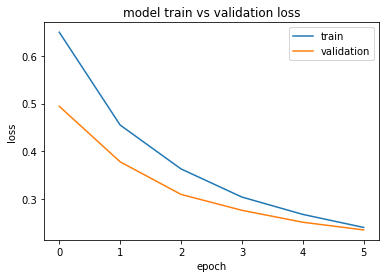

In [119]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [120]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [121]:
print(classification_report(X_test_targets, lstm_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       502
           1       0.97      0.99      0.98      3273
           2       0.92      0.92      0.92      7171
           3       0.94      0.86      0.90      7164
           4       0.93      0.96      0.94     40075
           5       0.90      0.82      0.86     19456
           6       0.95      0.99      0.97      1278

   micro avg       0.92      0.92      0.92     78919
   macro avg       0.94      0.93      0.93     78919
weighted avg       0.92      0.92      0.92     78919
 samples avg       0.92      0.92      0.92     78919



In [122]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

[[  480     0     0     0    22     0     0]
 [    7  3244     0     0    11    11     0]
 [  120    12  6595    25   146   273     0]
 [  202     0    60  6186   218   498     0]
 [  199    32   164   127 38544   996    13]
 [  267    63   331   229  2601 15911    54]
 [    6     0     0     0     2     1  1269]]


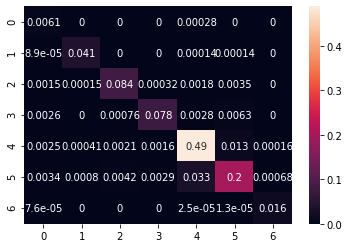

In [123]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

#### Via Transformer

In [195]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

     |████████████████████████████████| 434.0MB 42kB/s 
     |████████████████████████████████| 6.0MB 52.7MB/s 
     |████████████████████████████████| 471kB 50.8MB/s 
     |████████████████████████████████| 4.0MB 47.1MB/s 
     |████████████████████████████████| 4.0MB 46.2MB/s 
     |████████████████████████████████| 3.9MB 51.6MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3

In [ ]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token (vs 32 ?)
num_heads = 2  # Number of attention heads 
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(embed_dim, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(7, activation="softmax")(x)

transfo_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Train and Evaluate
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
transfo_history = transfo_model.fit(
    X_train_tok, X_train_targets, validation_split=0.2, batch_size=512, epochs=4 , \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
493/494 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.5442WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff686aa7950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

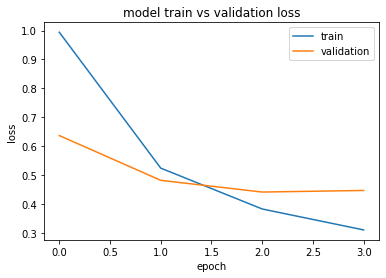

In [ ]:
plt.plot(transfo_history.history['loss'])
plt.plot(transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
transfo_pred = (transfo_model.predict(X_test_tok) >= 0.5).astype("int")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(classification_report(X_test_targets, transfo_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     10683
           1       0.79      0.83      0.81      5481
           2       0.81      0.69      0.75      9460
           3       0.96      0.93      0.94     39885
           4       0.83      0.81      0.82     13410

   micro avg       0.89      0.84      0.87     78919
   macro avg       0.84      0.79      0.81     78919
weighted avg       0.89      0.84      0.86     78919
 samples avg       0.84      0.84      0.84     78919



In [ ]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9098    90   215   433   781]
 [  870  4024   364   109   125]
 [ 2096   117  6185   502   650]
 [ 1393   177   388 37149   637]
 [ 1797    61   162   606 10890]]


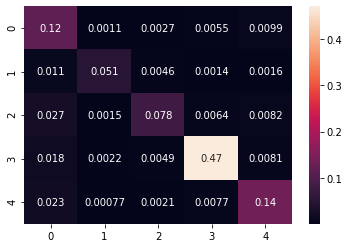

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

#### Via CamemBERT

In [ ]:
!pip install transformers==3.5.1
!pip install sentencepiece
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 6
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text = dataset['cleanSentence'].to_list()
labels = list(encoded_targets)

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

     |████████████████████████████████| 1.3MB 6.3MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 2.9MB 27.1MB/s 
     |████████████████████████████████| 1.1MB 35.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aeb2530dd28b18194070acc056e8d9a30cd7c8a88ff70590739bf25521531ddb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


ImportError: ignored

In [ ]:
def preprocess(raw_text, labels=None):
    encoded_batch = cam_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                pad_to_max_length=True,
                                                max_length=MAX_LEN,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if labels:
        labels = torch.tensor(labels)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Split train-validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(text, labels,
                                                            random_state=42, test_size=0.2)

In [ ]:
train_input_ids, train_attention_mask, train_labels = preprocess(train_inputs, train_labels)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_labels)

val_input_ids, val_attention_mask, validation_labels = preprocess(validation_inputs, validation_labels)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_labels)

In [ ]:
# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("Bert.pt")
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Unable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 7)

model.to(device) 

Unable to load trained model.
[Errno 2] No such file or directory: 'Bert.pt'


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
#Training parameters
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

In [ ]:
# Training & Validation
for epoch in range(0, epochs):
  print("")
  print(f'########## Epoch {epoch+1} / {epochs} ##########')
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t0

        # Report progress
        print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
    #
    # 'batch' contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: skills 
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)

    # Clear any previously calculated gradients before performing a backward pass
    model.zero_grad()        

    # Perform a forward pass (evaluate the model on this training batch)
    # the loss (because we provided skills) and the "logits"--the model
    # outputs prior to activation
    loss, logits = model(input_id, 
                          token_type_ids=None, 
                          attention_mask=attention_mask, 
                          labels=label)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. 'loss' is a Tensor containing a
    # single value; the '.item()' function just returns the Python value 
    # from the tensor
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)   

  if epoch > 0:
      if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
          # i.e. If there is not improvement
          consecutive_epochs_with_no_improve += 1
      else:
          # If there is improvement
          consecutive_epochs_with_no_improve = 0
          print("Model saved!")
          torch.save(model.state_dict(), "Bert.pt")

  # Measure how long this epoch took
  training_time = time.time() - t0

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
      }
  )

  print("epoch: {} \n".format(epoch + 1), file=outfile)
  print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
  print("Training Time: {} \n".format(training_time), file=outfile)

  if consecutive_epochs_with_no_improve == 2:
      print("Stop training : The loss has not changed since 2 epochs!")
      break


  # Tracking variables for validation
  eval_loss, eval_accuracy = 0, 0
  batch_count = 0

  t1 = time.time()
  # Validation of the model
  model.eval()

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      elapsed = time.time() - t1
      print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
      #
      # 'batch' contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: skills 
      input_id = batch[0].to(device)
      attention_mask = batch[1].to(device)
      label = batch[2].to(device)

      with torch.no_grad():
      # Forward pass, calculate logit predictions
          outputs =  model(input_id, token_type_ids=None, 
                            attention_mask=attention_mask,
                            labels=label)
          loss, logits = outputs[:2]

      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. 'loss' is a Tensor containing a
      # single value; the '.item()' function just returns the Python value 
      # from the tensor
      eval_loss += loss.item()

      # Move logits and labels to CPU if GPU is used
      logits = logits.detach().cpu().numpy()
      label_ids = label.to('cpu').numpy()
      predictions = np.argmax(logits, axis=1).flatten()

      tmp_eval_accuracy = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      if batch_count == 0:
          global_predictions = predictions
      else:
          global_predictions = np.append(global_predictions,predictions)
      batch_count += 1


  avg_validation_loss = eval_loss / len(validation_dataloader)   


  # Measure how long this epoch took
  validation_time = time.time() - t1

  print("")
  print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
  print("  Validation took: {:}".format(validation_time))
  print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
  # Calculate the average loss over all of the batches

  # Record all statistics from this epoch.
  validation_stats.append(
      {
          'Training Loss': avg_validation_loss,
          'Training Time': validation_time,
      }
  )

  print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
  print("Validation Time: {} \n".format(validation_time), file=outfile)
        
        
#with open('Bert_Metrics.json', 'w+') as outfile:
#    json.dump(training_stats, outfile)

#torch.save(model.state_dict(), "Bert.pt")
#print("Final Model saved!")


########## Epoch 1 / 6 ##########
Training...


AttributeError: ignored

In [ ]:
global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(validation_labels, global_preds, zero_division=0)
print("Report: {} \n".format(report))

confusion_matrix = metrics.confusion_matrix(validation_labels, global_preds)

print("Confusion Matrix: {} \n".format(confusion_matrix))

sns.heatmap(confusion_matrix, annot=True)


### Via lexical features analysis

#### Analyzing Part-of-Speech tags

In [55]:
def camembert_tag_reduction(tag):
    tag_reduc = ''
    if tag in ["VIMP","VINF","VPP","VPR","VS"]:
        tag_reduc = 'V'
    elif tag in ['PREF']:
        tag_reduc = 'NC'
    elif tag in ['CS', 'CC']:
        tag_reduc = 'C'
    elif tag in ['CLS', 'CLO', 'CLR']:
        tag_reduc = 'CL'
    elif tag in ['ADJWH']:
        tag_reduc = 'ADJ'
    elif tag == 'ADVWH':
        tag_reduc = 'ADV'
    elif tag in ["PROREL","PROWH"]:
        tag_reduc = 'PRO'
    elif tag in ['DETWH']:
        tag_reduc = 'DET'
    elif tag == 'PUNC':
        tag_reduc = 'PONCT'
    elif tag in ['P', 'P+D']:
        tag_reduc = 'PREP'  
    elif tag in ["O", "U"]:
        tag_reduc = 'ET'
    else:
        tag_reduc = tag
        
    return(tag_reduc)

In [56]:
!pip install sentencepiece
!pip install transformers==3.5.1

     |████████████████████████████████| 1.2MB 8.5MB/s 
     |████████████████████████████████| 1.3MB 8.0MB/s 
     |████████████████████████████████| 1.1MB 43.5MB/s 
     |████████████████████████████████| 2.9MB 51.3MB/s 
     |████████████████████████████████| 890kB 51.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=4226133cab0f0b1dac1a7acbeb2f2fd6fcf3788fde4ae42f3c933e1158f6a4dd
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Found existing installation: sentencepiece 0.1.95
    Uninstalling sentencepiece-0.1.95:
      Successfully uninstalled sentencepiece-0.1.95


In [57]:
#https://huggingface.co/gilf/french-camembert-postag-model
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("gilf/french-camembert-postag-model", padding=True, truncation = 128)
model = AutoModelForTokenClassification.from_pretrained("gilf/french-camembert-postag-model")

from transformers import pipeline

nlp_token_class = pipeline('ner', model=model, tokenizer=tokenizer)

In [58]:
sentence = dataset['cleanSentence'][4]
print(sentence)

moi mdr t trop nul


In [59]:
tags = nlp_token_class(sentence)
tags

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'PRO', 'index': 1, 'score': 0.984584629535675, 'word': '▁moi'},
 {'entity': 'NC', 'index': 2, 'score': 0.43410587310791016, 'word': '▁mdr'},
 {'entity': 'NC', 'index': 3, 'score': 0.7039426565170288, 'word': '▁t'},
 {'entity': 'ADV', 'index': 4, 'score': 0.998625636100769, 'word': '▁trop'},
 {'entity': 'ADJ', 'index': 5, 'score': 0.9971804022789001, 'word': '▁nul'}]

In [60]:
final_tags = []
for i in range(len(tags)):
    final_tags.append(tags[i]['entity'])
[camembert_tag_reduction(i) for i in final_tags]

['PRO', 'NC', 'NC', 'ADV', 'ADJ']

In [61]:
final_tags = []
for i in range(len(tags)):
    final_tags.append(tags[i]['word'])
[camembert_tag_reduction(i) for i in final_tags]

['▁moi', '▁mdr', '▁t', '▁trop', '▁nul']

In [62]:
def tag_extraction(s):
  tags = nlp_token_class(s)
  pos_tags = []
  word_toks = []
  for i in range(len(tags)):
    pos_tags.append(tags[i]['entity'])
    word_toks.append(tags[i]['words'])
  pos_list = [camembert_tag_reduction(i) for i in pos_tags]
  word_list = [camembert_tag_reduction(i) for i in word_toks]
  return pos_list, word_list

#### Static syntactic rules

In [104]:
#Encoding targets as one-hot vectors
arobases = final_dataset["Arobase"]
aro_encoder = LabelEncoder()
aro_encoder.fit(arobases)
encoded_arobases = aro_encoder.transform(arobases)

onehot_arobases = np_utils.to_categorical(encoded_arobases)
onehot_arobases

arobases_mapping = dict(zip(aro_encoder.classes_,aro_encoder.transform(aro_encoder.classes_)))
arobases.value_counts()

0.0    318090
1.0     44151
2.0     32351
Name: Arobase, dtype: int64

In [105]:
#Encoding targets as one-hot vectors
pronouns = final_dataset["Pronoun"]
pro_encoder = LabelEncoder()
pro_encoder.fit(pronouns)
encoded_pronouns = pro_encoder.transform(pronouns)

onehot_pronouns = np_utils.to_categorical(encoded_pronouns)
onehot_pronouns

pronouns_mapping = dict(zip(pro_encoder.classes_,pro_encoder.transform(pro_encoder.classes_)))
pronouns.value_counts()

1    310863
0     71887
2      6195
3      5647
Name: Pronoun, dtype: int64

##### Via Transformers

In [108]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

     |████████████████████████████████| 436.4MB 38kB/s 
     |████████████████████████████████| 6.0MB 58.1MB/s 
     |████████████████████████████████| 4.0MB 41.8MB/s 
     |████████████████████████████████| 471kB 57.4MB/s 
     |████████████████████████████████| 4.0MB 46.8MB/s 
     |████████████████████████████████| 3.9MB 43.1MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3

In [102]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [121]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

input1 = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(input1)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(EMBEDDING_DIM, activation="relu")(x)
dense1 = layers.Dropout(0.1)(x)

input2 = Input(shape=(3,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

input3 = Input(shape=(4,))
dense3 = Dense(EMBEDDING_DIM, activation='relu')(input3)

dense = Concatenate()([dense1, dense2, dense3])
out = Dense(7, activation='softmax')(dense)
targ_transfo_model = keras.Model(inputs = [input1, input2, input3], outputs = out)
targ_transfo_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [106]:
X_train_tok, X_test_tok, X_train_arobases, X_test_arobases, X_train_pronouns, X_test_pronouns, X_train_targets, X_test_targets = train_test_split(X_tok, onehot_arobases, onehot_pronouns, onehot_targets, test_size = 0.2, stratify = onehot_targets)

In [107]:
#
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

targ_transfo_history = targ_transfo_model.fit([X_train_tok, X_train_arobases, X_train_pronouns], X_train_targets, validation_split=0.2, epochs=6, batch_size = 1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

NameError: ignored

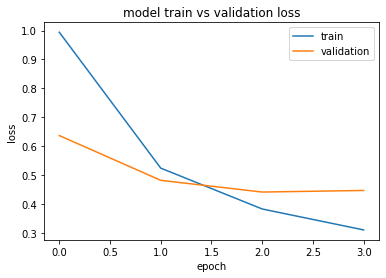

In [ ]:
plt.plot(transfo_history.history['loss'])
plt.plot(transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
transfo_pred = (transfo_model.predict(X_test_targets) >= 0.5).astype("int")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(classification_report(X_test_targets, transfo_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     10683
           1       0.79      0.83      0.81      5481
           2       0.81      0.69      0.75      9460
           3       0.96      0.93      0.94     39885
           4       0.83      0.81      0.82     13410

   micro avg       0.89      0.84      0.87     78919
   macro avg       0.84      0.79      0.81     78919
weighted avg       0.89      0.84      0.86     78919
 samples avg       0.84      0.84      0.84     78919



In [ ]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9098    90   215   433   781]
 [  870  4024   364   109   125]
 [ 2096   117  6185   502   650]
 [ 1393   177   388 37149   637]
 [ 1797    61   162   606 10890]]


##### Via CamemBERT

In [ ]:
import time
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertModel, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 10
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text = final_dataset['cleanSentence'].to_list()
targets = list(encoded_targets)
arobases = onehot_arobases
pronouns = onehot_pronouns

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

def preprocess(raw_text, arobases, pronouns, targets):
    encoded_batch = cam_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                pad_to_max_length=True,
                                                max_length=MAX_LEN,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    arobases = torch.tensor(arobases, dtype=torch.float)
    pronouns = torch.tensor(pronouns, dtype=torch.float)
    targets = torch.tensor(targets, dtype=torch.long)
    return encoded_batch['input_ids'], encoded_batch['attention_mask'], arobases, pronouns, targets


# Split train-validation
train_inputs, test_inputs, train_arobases, test_arobases, train_pronouns, test_pronouns, train_targets, test_targets = train_test_split(text, arobases, pronouns, targets, random_state=42, test_size=0.2, stratify=targets)

train_inputs, validation_inputs, train_arobases, validation_arobases, train_pronouns, validation_pronouns, train_targets, validation_targets = train_test_split(train_inputs, train_arobases, train_pronouns, train_targets,
                                                            random_state=42, test_size=0.2, stratify=train_targets)


train_input_ids, train_attention_mask, train_arobases, train_pronouns, train_targets = preprocess(train_inputs, train_arobases, train_pronouns, train_targets)


# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_arobases,
    train_pronouns,
    train_targets)

val_input_ids, val_attention_mask, validation_arobases, validation_pronouns, validation_targets = preprocess(validation_inputs, validation_arobases, validation_pronouns, validation_targets)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_arobases,
    validation_pronouns,
    validation_targets)

test_input_ids, test_attention_mask, test_arobases, test_pronouns, test_targets = preprocess(test_inputs, test_arobases, test_pronouns, test_targets)
# Combine the validation inputs into a TensorDataset
test_dataset = TensorDataset(
    test_input_ids,
    test_attention_mask,
    test_arobases,
    test_pronouns,
    test_targets)

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size)

class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        try:
            state_dict = torch.load("Bert_ST_Pred_Level.pt")
            print("Loading trained model...")
            self.bert = CamembertModel.from_pretrained(
            'camembert-base',
            state_dict=state_dict)
            print("Trained model loaded!")
        except Exception as e:
            print("Unable to load trained model.")
            print(e)
            self.bert = CamembertModel.from_pretrained(
                'camembert-base',
                num_labels = 5) 
        self.linear1 = nn.Linear(batch_size*768, 768)
        self.linear2 = nn.Linear(3, 768)
        self.linear3 = nn.Linear(4, 768)
        self.linear4 = nn.Linear(3*768, 7)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.2)
        self.soft = nn.Softmax(dim=-1)

    def forward(self, input_id, attention_mask, arobases, pronouns):
        sequence_output = self.bert(
               input_id, 
               attention_mask=attention_mask)
        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        cls_embedding = sequence_output[0][:, 0, :]

        linear2_output = self.linear2(arobases) 
        relu2_output = self.relu(linear2_output)

        linear3_output = self.linear3(pronouns) 
        relu3_output = self.relu(linear3_output)
        
        concat_output = torch.cat((cls_embedding, relu2_output, relu3_output),1)
        final_output = self.linear4(concat_output)
        output = self.soft(final_output)

        return final_output

criterion = nn.CrossEntropyLoss()
model = CustomBERTModel()
model.to(device) 

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

# Training & Validation
with open('Results_Bert_SAP_lab_T_10epochs_testmode.txt', 'w') as outfile:

    for epoch in range(0, epochs):

        print("")
        print(f'########## Epoch {epoch+1} / {epochs} ##########')
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode
        model.train()

        # For each batch of training data
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = time.time() - t0

                # Report progress
                print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

            # Unpack this training batch from our dataloader. 
            input_id = batch[0].to(device)
            attention_mask = batch[1].to(device)
            arobases = batch[2].to(device)
            pronouns = batch[3].to(device)
            targets = batch[4].to(device)

            # Clear any previously calculated gradients before performing a backward pass
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch)
            logits = model(input_id, 
            #                     token_type_ids=None, 
                                 attention_mask=attention_mask,
                                 arobases = arobases,
                                 pronouns = pronouns)
            
            loss = criterion(logits, targets)

            # Accumulate the training loss over all of the batches 
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches
        avg_train_loss = total_train_loss / len(train_dataloader)   

        if epoch > 0:
            if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
                # i.e. If there is not improvement
                consecutive_epochs_with_no_improve += 1
            else:
                # If there is improvement
                consecutive_epochs_with_no_improve = 0
                print("Model saved!")
                torch.save(model.state_dict(), "Bert_SAP_lab_Target.pt")

        # Measure how long this epoch took
        training_time = time.time() - t0

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Training Time': training_time,
            }
        )

        print("epoch: {} \n".format(epoch + 1), file=outfile)
        print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
        print("Training Time: {} \n".format(training_time), file=outfile)

        if consecutive_epochs_with_no_improve == 2:
            print("Stop training : The loss has not changed since 2 epochs!")
            break

        
        # Tracking variables for validation
        eval_loss, eval_accuracy = 0, 0
        batch_count = 0

        t1 = time.time()
        # Validation of the model
        model.eval()
        
        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Progress update every 40 batches.
            if batch_count % 40 == 0 and not batch_count == 0:
                # Calculate elapsed time in minutes.
                elapsed = time.time() - t1

                # Report progress
                print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')
            

            # Unpack this training batch from our dataloader. 
            input_id = batch[0].to(device)
            attention_mask = batch[1].to(device)
            arobases = batch[2].to(device)
            pronouns = batch[3].to(device)
            targets = batch[4].to(device)

            with torch.no_grad():
            # Forward pass, calculate logit predictions
                logits =  model(input_id, 
            #                     token_type_ids=None, 
                                 attention_mask=attention_mask,
                                 arobases = arobases,
                                 pronouns = pronouns)
            
                loss = criterion(logits, targets)

            # Accumulate the training loss over all of the batches
            eval_loss += loss.item()

            # Move logits and labels to CPU if GPU is used
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions = np.argmax(logits, axis=1).flatten()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            if batch_count == 0:
                global_predictions = predictions
            else:
                global_predictions = np.append(global_predictions,predictions)
            batch_count += 1

        
        avg_validation_loss = eval_loss / len(validation_dataloader)   


        # Measure how long this epoch took
        validation_time = time.time() - t1

        print("")
        print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
        print("  Validation took: {:}".format(validation_time))
        print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
        # Calculate the average loss over all of the batches

        # Record all statistics from this epoch.
        validation_stats.append(
            {
                'Training Loss': avg_validation_loss,
                'Training Time': validation_time,
            }
        )

        print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
        print("Validation Time: {} \n".format(validation_time), file=outfile)
        
        

    t2 = time.time()
    print("Test mode: \n")
    # Validation of the model
    model.eval()
    batch_count = 0
    test_loss, test_accuracy = 0, 0
    #Evaluating on dev set
    for batch in test_dataloader:
            
        # Progress update every 40 batches.
        if batch_count % 40 == 0 and not batch_count == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t2

            # Report progress
            print(f'  Batch {batch_count}  of  {len(test_dataloader)}    Elapsed: {format_time(elapsed)}.')
            

        # Unpack this training batch from our dataloader. 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        arobases = batch[2].to(device)
        pronouns = batch[3].to(device)
        targets = batch[4].to(device)

        with torch.no_grad():
        # Forward pass, calculate logit predictions
            logits =  model(input_id, 
        #                     token_type_ids=None, 
                                attention_mask=attention_mask,
                                arobases = arobases,
                                pronouns = pronouns)
            
            loss = criterion(logits, targets)

        # Accumulate the training loss over all of the batches 
        test_loss += loss.item()

        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = targets.to('cpu').numpy()
        predictions = np.argmax(logits, axis=1).flatten()

        tmp_test_accuracy = flat_accuracy(logits, label_ids)

        test_accuracy += tmp_test_accuracy
        if batch_count == 0:
            global_predictions = predictions
        else:
            global_predictions = np.append(global_predictions,predictions)
        batch_count += 1

print("Final Model saved!")
#with open('Bert_Metrics.json', 'w+') as outfile:
#    json.dump(training_stats, outfile)
torch.save(model.state_dict(), "Bert_SAP_lab_Target.pt")

avg_test_loss = test_loss / len(test_dataloader)   

# Measure how long this epoch took
test_time = time.time() - t2

global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(test_targets, global_preds, zero_division=0)

confusion_matrix = metrics.confusion_matrix(test_targets, global_preds)

with open('Results_Bert_SAP_lab_T_10epochs_testmode.txt', 'a') as f:
    print("", file=f)
    print("  Average test loss: {0:.2f}".format(avg_test_loss), file=f)
    print("  Test took: {:}".format(test_time), file=f)
    print("  Test Accuracy: {}".format(test_accuracy/batch_count), file=f)
    print("", file=f)
    print("Report on test set: {} \n".format(report), file=f)
    print("Confusion Matrix on test set: \n{} \n".format(confusion_matrix), file=f)

conf_plot = sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True)
fig = conf_plot.get_figure()
fig.savefig('Confusion_plot_Bert_SAP_lab_T.png') 

# Type prediction

## Based on Sentence only

#### Via Bi-LSTM

In [75]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(14, activation='softmax'))
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [76]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          26505600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               336896    
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_3 (Dense)              (None, 14)                2814      
Total params: 26,896,710
Trainable params: 391,110
Non-trainable params: 26,505,600
____________________________________

In [77]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, X_train_types, validation_split=0.2, epochs=6, batch_size =1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
247/247 [==============================] - 256s 1s/step - loss: 1.1514 - acc: 0.6688 - val_loss: 0.5988 - val_acc: 0.8251
Epoch 2/6
247/247 [==============================] - 243s 986ms/step - loss: 0.6148 - acc: 0.8210 - val_loss: 0.5167 - val_acc: 0.8478
Epoch 3/6
247/247 [==============================] - 244s 988ms/step - loss: 0.5332 - acc: 0.8444 - val_loss: 0.4495 - val_acc: 0.8675
Epoch 4/6
247/247 [==============================] - 248s 1s/step - loss: 0.4827 - acc: 0.8571 - val_loss: 0.4148 - val_acc: 0.8772
Epoch 5/6
247/247 [==============================] - 241s 976ms/step - loss: 0.4495 - acc: 0.8660 - val_loss: 0.3878 - val_acc: 0.8861
Epoch 6/6
247/247 [==============================] - 238s 962ms/step - loss: 0.4206 - acc: 0.8739 - val_loss: 0.3656 - val_acc: 0.8926


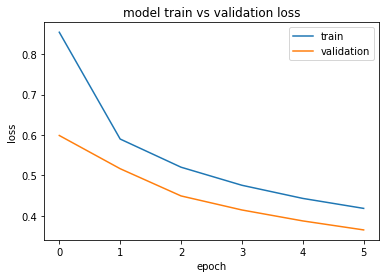

In [78]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [79]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [81]:
print(classification_report(X_test_types, lstm_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         0
           2       0.90      0.74      0.81      7413
           3       0.97      0.82      0.88      2474
           4       0.90      0.90      0.90     23431
           5       0.00      0.00      0.00         1
           6       0.82      0.68      0.74      2777
           7       0.91      0.25      0.39       312
           8       0.92      0.94      0.93     39998
           9       0.90      0.33      0.48       414
          10       0.84      0.39      0.54       908
          11       0.89      0.44      0.59       489
          12       0.95      0.69      0.79       693
          13       1.00      1.00      1.00         2

   micro avg       0.91      0.88      0.89     78919
   macro avg       0.71      0.51      0.58     78919
weighted avg       0.91      0.88      0.89     78919
 samples avg       0.88   

In [82]:
conf_matrix = confusion_matrix(X_test_types.argmax(axis=1), lstm_pred.argmax(axis=1))
print(conf_matrix)

[[    2     0     0     0     0     0     0     5     0     0     0     0
      0]
 [  516  5482     6   617     0    97     0   690     0     5     0     0
      0]
 [  114     8  2017   114     0    34     1   185     0     1     0     0
      0]
 [  597   239    23 21084     0    98     0  1345     2    29     4    10
      0]
 [    0     0     0     0     0     0     0     1     0     0     0     0
      0]
 [  360    41     3   183     0  1883     0   305     0     1     0     1
      0]
 [   82     5     1    60     0     2    78    80     0     3     1     0
      0]
 [ 1053   279    31   958     0   170     5 37437    13    19    17    16
      0]
 [   88     9     3    82     0     3     0    93   136     0     0     0
      0]
 [  130     9     6   202     0     9     2   193     0   357     0     0
      0]
 [   97    10     0    48     0     3     0   110     0     8   213     0
      0]
 [   63    16     0    26     0     5     0   105     0     0     3   475
      0]
 [  

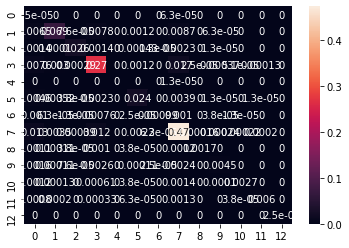

In [83]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

#### Via Transformer

In [ ]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

     |████████████████████████████████| 409.0MB 44kB/s 
     |████████████████████████████████| 4.0MB 52.1MB/s 
     |████████████████████████████████| 5.9MB 25.0MB/s 
     |████████████████████████████████| 4.0MB 43.7MB/s 
     |████████████████████████████████| 471kB 55.5MB/s 
     |████████████████████████████████| 3.8MB 48.2MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32

In [ ]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token (vs 32 ?)
num_heads = 2  # Number of attention heads 
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(embed_dim, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(14, activation="softmax")(x)

transfo_model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Train and Evaluate
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
transfo_history = transfo_model.fit(
    X_train_tok, X_train_types, validation_split=0.2, batch_size=512, epochs=4 , \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
493/494 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.5442WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7ff686aa7950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the

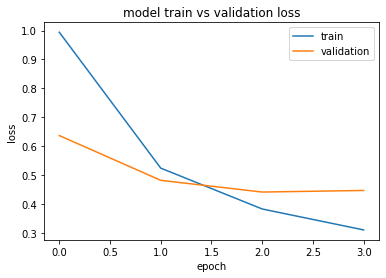

In [ ]:
plt.plot(transfo_history.history['loss'])
plt.plot(transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
transfo_pred = (transfo_model.predict(X_test_tok) >= 0.5).astype("int")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
print(classification_report(X_test_targets, transfo_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76     10683
           1       0.79      0.83      0.81      5481
           2       0.81      0.69      0.75      9460
           3       0.96      0.93      0.94     39885
           4       0.83      0.81      0.82     13410

   micro avg       0.89      0.84      0.87     78919
   macro avg       0.84      0.79      0.81     78919
weighted avg       0.89      0.84      0.86     78919
 samples avg       0.84      0.84      0.84     78919



In [ ]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), transfo_pred.argmax(axis=1))
print(conf_matrix)

[[ 9098    90   215   433   781]
 [  870  4024   364   109   125]
 [ 2096   117  6185   502   650]
 [ 1393   177   388 37149   637]
 [ 1797    61   162   606 10890]]


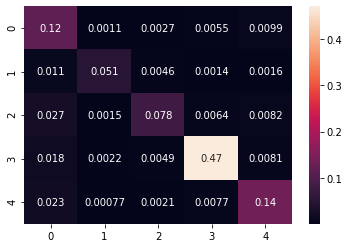

In [ ]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

### Via CamemBERT

In [ ]:
!pip install transformers==3.5.1
!pip install sentencepiece
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 6
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text = dataset['cleanSentence'].to_list()
labels = list(encoded_types)

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

     |████████████████████████████████| 1.3MB 6.3MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 2.9MB 27.1MB/s 
     |████████████████████████████████| 1.1MB 35.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aeb2530dd28b18194070acc056e8d9a30cd7c8a88ff70590739bf25521531ddb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


ImportError: ignored

In [ ]:
def preprocess(raw_text, labels=None):
    encoded_batch = cam_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                pad_to_max_length=True,
                                                max_length=MAX_LEN,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if labels:
        labels = torch.tensor(labels)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Split train-validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(text, labels,
                                                            random_state=42, test_size=0.2)

In [ ]:
train_input_ids, train_attention_mask, train_labels = preprocess(train_inputs, train_labels)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_labels)

val_input_ids, val_attention_mask, validation_labels = preprocess(validation_inputs, validation_labels)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_labels)

In [ ]:
# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("Bert.pt")
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Unable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 14)

model.to(device) 

Unable to load trained model.
[Errno 2] No such file or directory: 'Bert.pt'


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
#Training parameters
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

In [ ]:
# Training & Validation
for epoch in range(0, epochs):
  print("")
  print(f'########## Epoch {epoch+1} / {epochs} ##########')
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t0

        # Report progress
        print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
    #
    # 'batch' contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: skills 
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)

    # Clear any previously calculated gradients before performing a backward pass
    model.zero_grad()        

    # Perform a forward pass (evaluate the model on this training batch)
    # the loss (because we provided skills) and the "logits"--the model
    # outputs prior to activation
    loss, logits = model(input_id, 
                          token_type_ids=None, 
                          attention_mask=attention_mask, 
                          labels=label)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. 'loss' is a Tensor containing a
    # single value; the '.item()' function just returns the Python value 
    # from the tensor
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)   

  if epoch > 0:
      if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
          # i.e. If there is not improvement
          consecutive_epochs_with_no_improve += 1
      else:
          # If there is improvement
          consecutive_epochs_with_no_improve = 0
          print("Model saved!")
          torch.save(model.state_dict(), "Bert.pt")

  # Measure how long this epoch took
  training_time = time.time() - t0

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
      }
  )

  print("epoch: {} \n".format(epoch + 1), file=outfile)
  print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
  print("Training Time: {} \n".format(training_time), file=outfile)

  if consecutive_epochs_with_no_improve == 2:
      print("Stop training : The loss has not changed since 2 epochs!")
      break


  # Tracking variables for validation
  eval_loss, eval_accuracy = 0, 0
  batch_count = 0

  t1 = time.time()
  # Validation of the model
  model.eval()

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      elapsed = time.time() - t1
      print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
      #
      # 'batch' contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: skills 
      input_id = batch[0].to(device)
      attention_mask = batch[1].to(device)
      label = batch[2].to(device)

      with torch.no_grad():
      # Forward pass, calculate logit predictions
          outputs =  model(input_id, token_type_ids=None, 
                            attention_mask=attention_mask,
                            labels=label)
          loss, logits = outputs[:2]

      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. 'loss' is a Tensor containing a
      # single value; the '.item()' function just returns the Python value 
      # from the tensor
      eval_loss += loss.item()

      # Move logits and labels to CPU if GPU is used
      logits = logits.detach().cpu().numpy()
      label_ids = label.to('cpu').numpy()
      predictions = np.argmax(logits, axis=1).flatten()

      tmp_eval_accuracy = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      if batch_count == 0:
          global_predictions = predictions
      else:
          global_predictions = np.append(global_predictions,predictions)
      batch_count += 1


  avg_validation_loss = eval_loss / len(validation_dataloader)   


  # Measure how long this epoch took
  validation_time = time.time() - t1

  print("")
  print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
  print("  Validation took: {:}".format(validation_time))
  print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
  # Calculate the average loss over all of the batches

  # Record all statistics from this epoch.
  validation_stats.append(
      {
          'Training Loss': avg_validation_loss,
          'Training Time': validation_time,
      }
  )

  print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
  print("Validation Time: {} \n".format(validation_time), file=outfile)
        
        
#with open('Bert_Metrics.json', 'w+') as outfile:
#    json.dump(training_stats, outfile)

#torch.save(model.state_dict(), "Bert.pt")
#print("Final Model saved!")


########## Epoch 1 / 6 ##########
Training...


AttributeError: ignored

In [ ]:
global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(validation_labels, global_preds, zero_division=0)
print("Report: {} \n".format(report))

confusion_matrix = metrics.confusion_matrix(validation_labels, global_preds)

print("Confusion Matrix: {} \n".format(confusion_matrix))

sns.heatmap(confusion_matrix, annot=True)


## Based on sentence + target

### Via Bi-LSTM

In [103]:
input1 = Input(shape=(maxlen,))
embed1 = Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False)(input1)
bdlstm1 = Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(embed1)
dense1 = Dense(EMBEDDING_DIM, activation='relu')(bdlstm1)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(14, activation='softmax')(dense)
bilstm_model = keras.Model(inputs = [input1, input2], outputs = out)
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [104]:
bilstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 150, 200)     26505600    input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 256)          336896      embedding_6[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 7)]          0                                            
____________________________________________________________________________________________

In [105]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

bilstm_history = bilstm_model.fit([X_train_tok, X_train_targets], X_train_types, validation_split=0.2, epochs=6, batch_size = 1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
247/247 [==============================] - 254s 1s/step - loss: 0.9568 - acc: 0.7433 - val_loss: 0.3205 - val_acc: 0.9005
Epoch 2/6
247/247 [==============================] - 248s 1s/step - loss: 0.3004 - acc: 0.9072 - val_loss: 0.2409 - val_acc: 0.9257
Epoch 3/6
247/247 [==============================] - 246s 998ms/step - loss: 0.2370 - acc: 0.9259 - val_loss: 0.2160 - val_acc: 0.9293
Epoch 4/6
247/247 [==============================] - 246s 996ms/step - loss: 0.1961 - acc: 0.9380 - val_loss: 0.1738 - val_acc: 0.9486
Epoch 5/6
247/247 [==============================] - 245s 993ms/step - loss: 0.1655 - acc: 0.9486 - val_loss: 0.1574 - val_acc: 0.9543
Epoch 6/6
247/247 [==============================] - 242s 978ms/step - loss: 0.1444 - acc: 0.9557 - val_loss: 0.1429 - val_acc: 0.9599


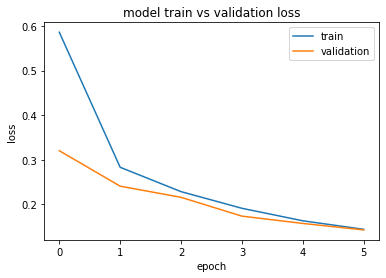

In [106]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [107]:
bilstm_pred = (bilstm_model.predict([X_test_tok, X_test_targets]) >= 0.5).astype("int")

In [108]:
print(classification_report(X_test_types, bilstm_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         0
           2       0.90      0.90      0.90      7413
           3       0.98      0.92      0.94      2474
           4       0.95      0.94      0.95     23431
           5       0.00      0.00      0.00         1
           6       0.90      0.82      0.86      2777
           7       0.86      0.58      0.69       312
           8       1.00      1.00      1.00     39998
           9       0.96      0.75      0.84       414
          10       0.93      0.50      0.65       908
          11       0.89      0.71      0.79       489
          12       0.94      0.82      0.88       693
          13       1.00      1.00      1.00         2

   micro avg       0.97      0.95      0.96     78919
   macro avg       0.74      0.64      0.68     78919
weighted avg       0.97      0.95      0.96     78919
 samples avg       0.95   

In [111]:
conf_matrix = confusion_matrix(X_test_targets.argmax(axis=1), bilstm_pred.argmax(axis=1))
print(conf_matrix)

[[   18     0   182    11   184     0     4     0     0     7    52     5
      5     2]
 [   26     0   277    53  2626     0   157     3     0    47    84   123
     31     0]
 [  126     0  1011   905  4484     0   340    28     0   140    44    92
     17     0]
 [  140     0  1248   882  3965     0   669    47     0    65    35    22
    185     0]
 [    0     0     0     0     0     0     0     0 39827     0     0     0
      0     0]
 [ 1326     0  4466   421 11100     0  1151   130     0    62   231   136
    362     0]
 [   18     0   193    49   831     0   212     3     0     1    42    11
      5     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    0     0     0  

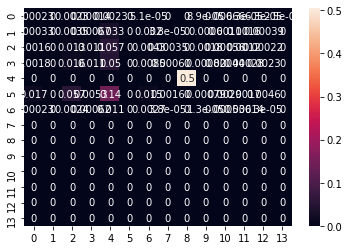

In [112]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via Transformer

In [113]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

     |████████████████████████████████| 399.6MB 40kB/s 
     |████████████████████████████████| 6.0MB 49.4MB/s 
     |████████████████████████████████| 4.0MB 48.5MB/s 
     |████████████████████████████████| 471kB 50.9MB/s 
     |████████████████████████████████| 4.0MB 47.8MB/s 
     |████████████████████████████████| 3.8MB 18.2MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10

In [114]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [115]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

input1 = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(input1)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(EMBEDDING_DIM, activation="relu")(x)
dense1 = layers.Dropout(0.1)(x)

input2 = Input(shape=(7,))
dense2 = Dense(EMBEDDING_DIM, activation='relu')(input2)

dense = Concatenate()([dense1, dense2])
out = Dense(14, activation='softmax')(dense)
targ_transfo_model = keras.Model(inputs = [input1, input2], outputs = out)
targ_transfo_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [116]:
targ_transfo_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
token_and_position_embedding (T (None, 150, 32)      4245696     input_7[0][0]                    
__________________________________________________________________________________________________
transformer_block (TransformerB (None, 150, 32)      10656       token_and_position_embedding[0][0
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 32)           0           transformer_block[0][0]          
____________________________________________________________________________________________

In [117]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

targ_transfo_history = targ_transfo_model.fit([X_train_tok, X_train_targets], X_train_types, validation_split=0.2, epochs=6, batch_size = 512, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
494/494 [==============================] - 39s 77ms/step - loss: 0.8834 - acc: 0.7388 - val_loss: 0.2251 - val_acc: 0.9379
Epoch 2/6
494/494 [==============================] - 37s 75ms/step - loss: 0.1807 - acc: 0.9500 - val_loss: 0.1294 - val_acc: 0.9651
Epoch 3/6
494/494 [==============================] - 37s 74ms/step - loss: 0.0892 - acc: 0.9761 - val_loss: 0.1177 - val_acc: 0.9675
Epoch 4/6
494/494 [==============================] - 37s 75ms/step - loss: 0.0623 - acc: 0.9829 - val_loss: 0.1193 - val_acc: 0.9708


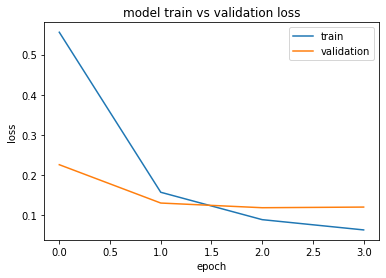

In [118]:
plt.plot(targ_transfo_history.history['loss'])
plt.plot(targ_transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [119]:
targ_transfo_pred = (targ_transfo_model.predict([X_test_tok, X_test_targets]) >= 0.5).astype("int")

In [120]:
print(classification_report(X_test_types, targ_transfo_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.00      0.00      0.00         0
           2       0.95      0.90      0.92      7413
           3       0.98      0.97      0.98      2474
           4       0.95      0.97      0.96     23431
           5       0.00      0.00      0.00         1
           6       0.89      0.90      0.90      2777
           7       0.86      0.73      0.79       312
           8       1.00      1.00      1.00     39998
           9       0.90      0.87      0.89       414
          10       0.83      0.69      0.75       908
          11       0.90      0.80      0.85       489
          12       0.95      0.92      0.93       693
          13       1.00      1.00      1.00         2

   micro avg       0.97      0.97      0.97     78919
   macro avg       0.80      0.71      0.73     78919
weighted avg       0.97      0.97      0.97     78919
 samples avg       0.97   

In [121]:
conf_matrix = confusion_matrix(X_test_types.argmax(axis=1), targ_transfo_pred.argmax(axis=1))
print(conf_matrix)

[[    3     4     0     0     0     0     0     0     0     0     0     0
      0]
 [   88  6690    12   477     0    92     6     0    12    22     2    12
      0]
 [   21     2  2402    32     0    10     1     0     1     0     1     4
      0]
 [  129   204    18 22798     0   141    18     0    19    74    21     9
      0]
 [    1     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   37    66     7   155     0  2498     2     0     0     9     1     2
      0]
 [   17    10     1    34     0     4   228     0     3     9     6     0
      0]
 [   13    34     4    89     0    18     1 39827     2     7     2     1
      0]
 [    7     4     0    36     0     3     0     0   362     1     1     0
      0]
 [   22    14     5   216     0    14     6     0     0   626     5     0
      0]
 [   28     7     0    35     0    12     1     0     0    10   390     6
      0]
 [    9    17     0    21     0     0     3     0     3     0     2   638
      0]
 [  

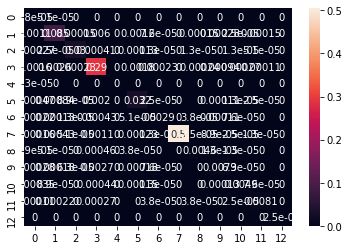

In [122]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

# Class prediction

#### Via Bi-LSTM

In [87]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[w2v_embedding_vectors], input_length=maxlen, trainable=False))
#Bi-LSTM
lstm_model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [88]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 200)          26505600  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 26,894,097
Trainable params: 388,497
Non-trainable params: 26,505,600
_________________________________________________________________


In [89]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, X_train_class, validation_split=0.2, epochs=6, batch_size =1024, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/6
247/247 [==============================] - 253s 1s/step - loss: 0.4055 - acc: 0.8183 - val_loss: 0.2494 - val_acc: 0.9033
Epoch 2/6
247/247 [==============================] - 243s 985ms/step - loss: 0.2480 - acc: 0.9025 - val_loss: 0.2171 - val_acc: 0.9180
Epoch 3/6
247/247 [==============================] - 246s 997ms/step - loss: 0.2120 - acc: 0.9191 - val_loss: 0.1977 - val_acc: 0.9269
Epoch 4/6
247/247 [==============================] - 243s 982ms/step - loss: 0.1901 - acc: 0.9284 - val_loss: 0.1943 - val_acc: 0.9290
Epoch 5/6
247/247 [==============================] - 238s 964ms/step - loss: 0.1749 - acc: 0.9352 - val_loss: 0.1783 - val_acc: 0.9367
Epoch 6/6
247/247 [==============================] - 238s 963ms/step - loss: 0.1651 - acc: 0.9397 - val_loss: 0.1714 - val_acc: 0.9412


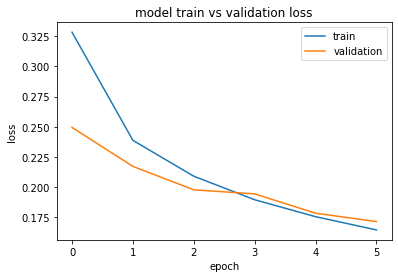

In [90]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [91]:
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [92]:
print(classification_report(X_test_class, lstm_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     39995
           1       0.95      0.94      0.94     38924

    accuracy                           0.94     78919
   macro avg       0.94      0.94      0.94     78919
weighted avg       0.94      0.94      0.94     78919



In [93]:
conf_matrix = confusion_matrix(X_test_class, lstm_pred)
print(conf_matrix)

[[37923  2072]
 [ 2461 36463]]


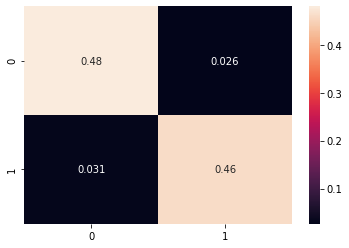

In [94]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

#### Via Transformer

In [123]:
#Implement a Transformer block as a layer

!pip install tf-nightly

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [124]:
#Implement embedding layer
#Two seperate embedding layers, one for tokens, one for token index (positions).

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [125]:
#Create classifier model using transformer layer

embed_dim = 32  # Embedding size for each token (vs 32 ?)
num_heads = 2  # Number of attention heads 
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(embed_dim, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

transfo_model = keras.Model(inputs=inputs, outputs=outputs)
transfo_model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

In [126]:
#Train and Evaluate
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

transfo_history = transfo_model.fit(
    X_train_tok, X_train_class, validation_split=0.2, batch_size=512, epochs=6 , \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Epoch 1/4
494/494 [==============================] - 39s 76ms/step - loss: 0.5135 - accuracy: 0.7025 - val_loss: 0.1788 - val_accuracy: 0.9378
Epoch 2/4
494/494 [==============================] - 37s 75ms/step - loss: 0.1495 - accuracy: 0.9496 - val_loss: 0.1620 - val_accuracy: 0.9467
Epoch 3/4
494/494 [==============================] - 37s 75ms/step - loss: 0.1088 - accuracy: 0.9661 - val_loss: 0.1679 - val_accuracy: 0.9466


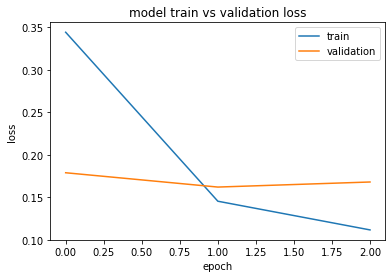

In [127]:
plt.plot(transfo_history.history['loss'])
plt.plot(transfo_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [128]:
transfo_pred = (transfo_model.predict(X_test_tok) >= 0.5).astype("int")

In [129]:
print(classification_report(X_test_class, transfo_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     39995
           1       0.94      0.95      0.95     38924

    accuracy                           0.95     78919
   macro avg       0.95      0.95      0.95     78919
weighted avg       0.95      0.95      0.95     78919



In [130]:
conf_matrix = confusion_matrix(X_test_class, transfo_pred)
print(conf_matrix)

[[37620  2375]
 [ 1808 37116]]


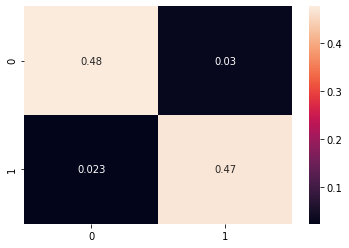

In [131]:
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True)

In [ ]:
#lstm_model.save("BiLSTM")

### Via CamemBERT

In [ ]:
!pip install transformers==3.5.1
!pip install sentencepiece
import torch
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

MAX_LEN = 128
epochs = 6
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text = dataset['cleanSentence'].to_list()
labels = dataset['Class'].to_list()

cam_tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base', do_lower_case=True)

     |████████████████████████████████| 1.3MB 6.3MB/s 
     |████████████████████████████████| 890kB 16.9MB/s 
     |████████████████████████████████| 2.9MB 27.1MB/s 
     |████████████████████████████████| 1.1MB 35.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=aeb2530dd28b18194070acc056e8d9a30cd7c8a88ff70590739bf25521531ddb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


ImportError: ignored

In [ ]:
def preprocess(raw_text, labels=None):
    encoded_batch = cam_tokenizer.batch_encode_plus(raw_text,
                                                truncation=True,
                                                add_special_tokens=True,
                                                pad_to_max_length=True,
                                                max_length=MAX_LEN,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if labels:
        labels = torch.tensor(labels)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], labels
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Split train-validation
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(text, labels,
                                                            random_state=42, test_size=0.2)

In [ ]:
train_input_ids, train_attention_mask, train_labels = preprocess(train_inputs, train_labels)
# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    train_input_ids,
    train_attention_mask,
    train_labels)

val_input_ids, val_attention_mask, validation_labels = preprocess(validation_inputs, validation_labels)
# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    val_input_ids,
    val_attention_mask,
    validation_labels)

In [ ]:
# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [ ]:
try:
    state_dict = torch.load("Bert.pt")
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict)
    print("Trained model loaded!")
except Exception as e:
    print("Unable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 2)

model.to(device) 

Unable to load trained model.
[Errno 2] No such file or directory: 'Bert.pt'


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

In [ ]:
#Training parameters
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )


# Training loop
training_stats = []
validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

In [ ]:
# Training & Validation
for epoch in range(0, epochs):
  print("")
  print(f'########## Epoch {epoch+1} / {epochs} ##########')
  print('Training...')

  # Measure how long the training epoch takes.
  t0 = time.time()

  # Reset the total loss for this epoch.
  total_train_loss = 0

  # Put the model into training mode
  model.train()

  # For each batch of training data
  for step, batch in enumerate(train_dataloader):
    # Progress update every 40 batches.
    if step % 40 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = time.time() - t0

        # Report progress
        print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

    # Unpack this training batch from our dataloader. 
    #
    # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
    #
    # 'batch' contains three pytorch tensors:
    #   [0]: input ids 
    #   [1]: attention masks
    #   [2]: skills 
    input_id = batch[0].to(device)
    attention_mask = batch[1].to(device)
    label = batch[2].to(device)

    # Clear any previously calculated gradients before performing a backward pass
    model.zero_grad()        

    # Perform a forward pass (evaluate the model on this training batch)
    # the loss (because we provided skills) and the "logits"--the model
    # outputs prior to activation
    loss, logits = model(input_id, 
                          token_type_ids=None, 
                          attention_mask=attention_mask, 
                          labels=label)

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. 'loss' is a Tensor containing a
    # single value; the '.item()' function just returns the Python value 
    # from the tensor
    total_train_loss += loss.item()

    # Perform a backward pass to calculate the gradients
    loss.backward()

    # Clip the norm of the gradients to 1.0
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

  # Calculate the average loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)   

  if epoch > 0:
      if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
          # i.e. If there is not improvement
          consecutive_epochs_with_no_improve += 1
      else:
          # If there is improvement
          consecutive_epochs_with_no_improve = 0
          print("Model saved!")
          torch.save(model.state_dict(), "Bert.pt")

  # Measure how long this epoch took
  training_time = time.time() - t0

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epoch took: {:}".format(training_time))

  # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch + 1,
          'Training Loss': avg_train_loss,
          'Training Time': training_time,
      }
  )

  print("epoch: {} \n".format(epoch + 1), file=outfile)
  print("Training Loss: {} \n".format(avg_train_loss), file=outfile)
  print("Training Time: {} \n".format(training_time), file=outfile)

  if consecutive_epochs_with_no_improve == 2:
      print("Stop training : The loss has not changed since 2 epochs!")
      break


  # Tracking variables for validation
  eval_loss, eval_accuracy = 0, 0
  batch_count = 0

  t1 = time.time()
  # Validation of the model
  model.eval()

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      elapsed = time.time() - t1
      print(f'  Batch {batch_count}  of  {len(validation_dataloader)}    Elapsed: {format_time(elapsed)}.')

      # Unpack this training batch from our dataloader. 
      #
      # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
      #
      # 'batch' contains three pytorch tensors:
      #   [0]: input ids 
      #   [1]: attention masks
      #   [2]: skills 
      input_id = batch[0].to(device)
      attention_mask = batch[1].to(device)
      label = batch[2].to(device)

      with torch.no_grad():
      # Forward pass, calculate logit predictions
          outputs =  model(input_id, token_type_ids=None, 
                            attention_mask=attention_mask,
                            labels=label)
          loss, logits = outputs[:2]

      # Accumulate the training loss over all of the batches so that we can
      # calculate the average loss at the end. 'loss' is a Tensor containing a
      # single value; the '.item()' function just returns the Python value 
      # from the tensor
      eval_loss += loss.item()

      # Move logits and labels to CPU if GPU is used
      logits = logits.detach().cpu().numpy()
      label_ids = label.to('cpu').numpy()
      predictions = np.argmax(logits, axis=1).flatten()

      tmp_eval_accuracy = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      if batch_count == 0:
          global_predictions = predictions
      else:
          global_predictions = np.append(global_predictions,predictions)
      batch_count += 1


  avg_validation_loss = eval_loss / len(validation_dataloader)   


  # Measure how long this epoch took
  validation_time = time.time() - t1

  print("")
  print("  Average validation loss: {0:.2f}".format(avg_validation_loss))
  print("  Validation took: {:}".format(validation_time))
  print("  Validation Accuracy: {}".format(eval_accuracy/batch_count))
  # Calculate the average loss over all of the batches

  # Record all statistics from this epoch.
  validation_stats.append(
      {
          'Training Loss': avg_validation_loss,
          'Training Time': validation_time,
      }
  )

  print("Validation Loss: {} \n".format(avg_validation_loss), file=outfile)
  print("Validation Time: {} \n".format(validation_time), file=outfile)
        
        
#with open('Bert_Metrics.json', 'w+') as outfile:
#    json.dump(training_stats, outfile)

#torch.save(model.state_dict(), "Bert.pt")
#print("Final Model saved!")


########## Epoch 1 / 6 ##########
Training...


AttributeError: ignored

In [ ]:
global_preds = torch.from_numpy(global_predictions)

report = metrics.classification_report(validation_labels, global_preds, zero_division=0)
print("Report: {} \n".format(report))

confusion_matrix = metrics.confusion_matrix(validation_labels, global_preds)

print("Confusion Matrix: {} \n".format(confusion_matrix))

sns.heatmap(confusion_matrix, annot=True)


# Feature analysis

### Sentiment analysis

In [ ]:
!pip install vaderSentiment_fr
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

     |████████████████████████████████| 235kB 5.8MB/s 
     |████████████████████████████████| 245kB 49.0MB/s 
  Created wheel for vaderSentiment-fr: filename=vaderSentiment_fr-1.2-cp37-none-any.whl size=232216 sha256=c232af99699787ebdf86243077aace094bfc6417e1ed82a6e4285f39d98d134d
  Stored in directory: /root/.cache/pip/wheels/a1/3f/c5/0aca890f5c576a804800875e10035a2a0f8bd808952cd82bdf
Successfully built vaderSentiment-fr
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [109]:
vader.polarity_scores('Moi mdr t trop nul')

NameError: ignored

In [ ]:
vader.polarity_scores_max('visage avec des larmes de joie')

visage --> sage
Fuzzy Ratio : 80
Pas pris en compte car < 85
avec --> avare
Fuzzy Ratio : 67
Pas pris en compte car < 85
Processing time : 0.36016273498535156


{'compound': -0.1531, 'neg': 0.264, 'neu': 0.556, 'pos': 0.181}

In [ ]:
def get_vader_sent(val):
  if val >= 0.05:
    return "pos"
  elif val <= -0.05:
    return "neg"
  else:
    return "neu"

In [ ]:
# Checking with non tokenized toxic data
vader_toxic = []
sentiments_toxic = dataset.loc[dataset['Class'] == 1]["cleanSentence"].tolist()

for i in range(len(sentiments_toxic)):
  vader_toxic.append(vader.polarity_scores(str(sentiments_toxic[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_toxic)):
  comp.append(vader_toxic[j]['compound'])
  pos.append(vader_toxic[j]['pos'])
  neg.append(vader_toxic[j]['neg'])
  neu.append(vader_toxic[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  -0.13845125929507032 Positive:  0.06868095460782297 Neutral:  0.7195407851258535 Negative : 0.21178063445240752


In [ ]:
# Checking with non tokenized clean data
vader_clean = []
sentiments_clean = dataset.loc[dataset['Class'] == 0]["cleanSentence"].tolist()

for i in range(len(sentiments_clean)):
  vader_clean.append(vader.polarity_scores(str(sentiments_clean[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_clean)):
  comp.append(vader_clean[j]['compound'])
  pos.append(vader_clean[j]['pos'])
  neg.append(vader_clean[j]['neg'])
  neu.append(vader_clean[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  0.1103306954999951 Positive:  0.1261536849999933 Neutral:  0.8205530599999965 Negative : 0.053292799999998926


In [ ]:
# Checking with non tokenized VERY toxic data
vader_toxic = []
sentiments_toxic = dataset.loc[dataset['Level'] == "HIGH"]["cleanSentence"].tolist()

for i in range(len(sentiments_toxic)):
  vader_toxic.append(vader.polarity_scores(str(sentiments_toxic[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_toxic)):
  comp.append(vader_toxic[j]['compound'])
  pos.append(vader_toxic[j]['pos'])
  neg.append(vader_toxic[j]['neg'])
  neu.append(vader_toxic[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

Compound:  -0.1677027025000968 Positive:  0.06561415345402831 Neutral:  0.7009890175793817 Negative : 0.23339883428913538


### KMeans for W2V embeddings

In [110]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from itertools import cycle

def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(word_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers]
    closest_words_idxs = [x[1] for x in closest_points]

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {}
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words)
    df.index = df.index+1

    return df

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


def display_cloud(cluster_num, cmap, words_df):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap)
    wordcloud = wc.generate(' '.join([word for word in words_df['Cluster #' + str(cluster_num).zfill(2)]]))
    plt.figure(cluster_num)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')


cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

NUM_CLUSTERS = 10
EMBEDDING_DIM = 200

In [112]:
len(final_dataset["finalSentence"].loc[final_dataset["Class"] == 0])

199999

In [113]:
w2v_model_hateful = gensim.models.Word2Vec(sentences=final_dataset["finalSentence"].loc[final_dataset["Class"] == 1], size=EMBEDDING_DIM, window=5, min_count=5)
w2v_model_neutral = gensim.models.Word2Vec(sentences=final_dataset["finalSentence"].loc[final_dataset["Class"] == 0], size=EMBEDDING_DIM, window=5, min_count=5)

In [114]:
centers_hateful, clusters_hateful = clustering_on_wordvecs(w2v_model_hateful.wv.syn0, NUM_CLUSTERS)
centroid_map_hateful = dict(zip(w2v_model_hateful.wv.index2word, clusters_hateful))

In [115]:
#Getting words in each cluster that are closest to the cluster center
top_words_hateful = get_top_words(w2v_model_hateful.wv.index2word, 20, centers_hateful, w2v_model_hateful.wv.syn0)
top_words_hateful

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10
1,classement,undestand,soldats,chess,découvre,bau,pettase,profiter,odorat,taille
2,faciès,necessary,politiciens,them,devais,pots,toys,convaincre,démontrer,phobie
3,blaze,lacks,ignares,not,maîtrise,kalachnikovs,smb,conduire,saurait,compagne
4,dictionnaire,tousssz,médecins,than,taime,gafa,vs3,retirer,cfa,bagarre
5,rhone,daronnnn,seuls,ruvol,retiens,vestiges,subbed,reprendre,rancune,dignité
6,rétractation,differentiation,monstres,think,voudras,profiteurs,homer,causer,recours,scène
7,bordereau,vooo,services,enemies,souviens,tirs,narrator,retenir,réciproque,vitesse
8,wlsh,rape,entreprises,54,pourrai,rosters,slurs,compote,nécessaires,vengeance
9,astéroïde,topic,commerçants,retouraffectif,regardais,banquiers,agnès,manquer,avalées,pièce
10,compagnon,nikeeee,bagnoles,because,cite,votes,cyrto,proteger,assaisonner,décision


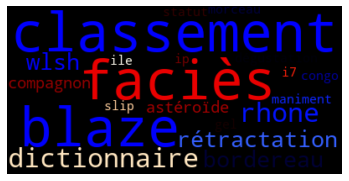

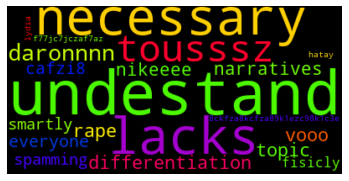

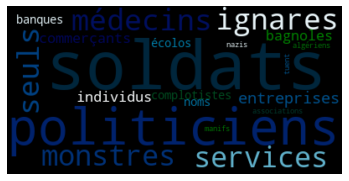

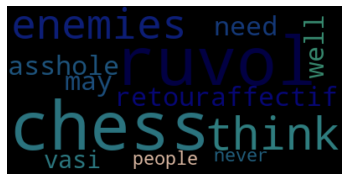

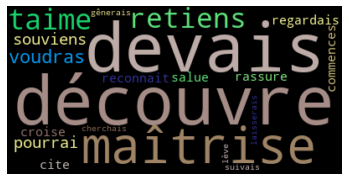

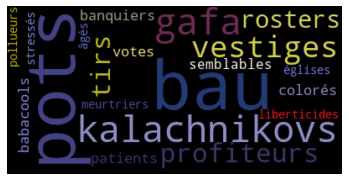

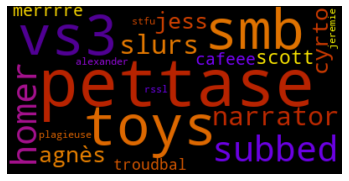

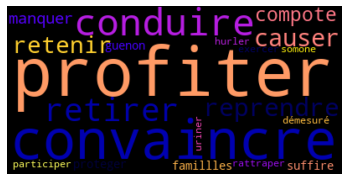

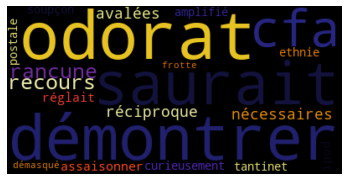

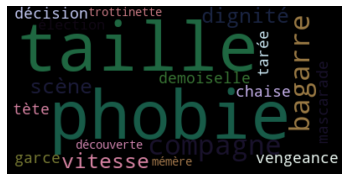

In [116]:
#Displaying clusters via WordClouds
for fi in range(NUM_CLUSTERS):
    col = next(cmaps)
    display_cloud(fi+1, col, top_words_hateful)


# Error Analysis

### Based on top prediction confidence

In [ ]:
proba_pred = bilstm_model.predict([X_test_tok, X_test_targets, X_test_emoji.toarray()])

y_test_pred = proba_pred.argmax(axis = 1)
y_test_tok_class = y_test_tok.argmax(axis = 1)

test['correctly_classified'] = y_test_tok_class == y_test_pred
test['pred_confidence'] = proba_pred.max(axis = 1)
test['Expected_label'] = y_test_tok_class
test['Predicted_label'] = y_test_pred

replace_class_pred = {number : name for name, number in labels_mapping.items()}
test['Expected_label'] = test['Expected_label'].replace(replace_class_pred)
test['Predicted_label'] = test['Predicted_label'].replace(replace_class_pred)

In [ ]:
test[test.correctly_classified==False].sort_values(by = 'pred_confidence', ascending = False)[['Sentence', 'Type', 'Target', 'Expected_label', 'Predicted_label', 'correctly_classified', 'pred_confidence']].to_csv('model_errors_sorted_by_model_confidence.csv')
test[test.correctly_classified==False].sort_values(by = 'pred_confidence', ascending = False)[['Sentence', 'Type', 'Target', 'Expected_label', 'Predicted_label', 'correctly_classified', 'pred_confidence']].head(50)

### Further dataset inspection

In [88]:
print("\"Nul\" in Low sentences: ", dataset_low["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in High sentences: ", dataset_high["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("nul").sum())
print("\"Nul\" in Neutral sentences: ", neutral["Sentence"].str.count("nul").sum())

"Nul" in Low sentences:  4786
"Nul" in Medium sentences:  5633
"Nul" in High sentences:  1018
"Nul" in Very_High sentences:  1783
"Nul" in Neutral sentences:  185


In [87]:
print("\"Conne\" in Low sentences: ", dataset_low["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in High sentences: ", dataset_high["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("conne").sum())
print("\"Conne\" in Neutral sentences: ", neutral["Sentence"].str.count("conne").sum())

"Conne" in Low sentences:  738
"Conne" in Medium sentences:  639
"Conne" in High sentences:  926
"Conne" in Very_High sentences:  1170
"Conne" in Neutral sentences:  754


In [86]:
print("\"Gay\" in Low sentences: ", dataset_low["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in High sentences: ", dataset_high["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("gay").sum())
print("\"Gay\" in Neutral sentences: ", neutral["Sentence"].str.count("gay").sum())

"Gay" in Low sentences:  290
"Gay" in Medium sentences:  869
"Gay" in High sentences:  2189
"Gay" in Very_High sentences:  1001
"Gay" in Neutral sentences:  97


In [89]:
print("\"Connard\" in Low sentences: ", dataset_low["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in Medium sentences: ", dataset_medium["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in High sentences: ", dataset_high["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in Very_High sentences: ", dataset_veryhigh["cleanSentence"].str.count("connard").sum())
print("\"Connard\" in Neutral sentences: ", neutral["Sentence"].str.count("connard").sum())

"Connard" in Low sentences:  51
"Connard" in Medium sentences:  2714
"Connard" in High sentences:  1603
"Connard" in Very_High sentences:  2379
"Connard" in Neutral sentences:  31


In [130]:
#Removing frequent words
#FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
FREQWORDS = ['être', 'ses', 'rien', 'son', 'm', 'juste', 'ont', 'as', 'lui', 'peut', 'aussi', 'dire', 'alors', 'mec', 'car', 'pas', 'ils', 'vraiment', 'même', 'es', 'toi', 'quand', 'ton', 'nous', 'tes', 'ces', 'trop', 'te', 'quoi', 'par', 'n', 'fait', 'vidéo', 'sont', 'ou', 'mon', 'y', 'suis', 'ta', 'ma', 'sa', 'me', 's', 'meme', 'moi', 'je', 'il', 'tu', 'j', 'vous', 'on', 't', 'plus', 'ai', 'se', 'elle', 'faire', 'cette', 'bien', 'de', 'est', 'la', 'et', 'le','les','c','que','des','a','un','en','à', 'pour','qui', 'l', 'd', 'une', 'ce', 'mais', 'qu', 'ne', 'ça', 'dans','du', 'sur', 'avec', 'tout', 'au', 'si', 'comme']

dataset_low_wo_freq = dataset_low.copy()
dataset_medium_wo_freq = dataset_medium.copy()
dataset_high_wo_freq = dataset_high.copy()
dataset_veryhigh_wo_freq = dataset_veryhigh.copy()
neutral_wo_freq = neutral.copy()

neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(lambda x: x.lower())
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_punctuations)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_URL)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_html)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_special)

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

dataset_low_wo_freq['cleanSentence'] = dataset_low_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_medium_wo_freq['cleanSentence'] = dataset_medium_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_high_wo_freq['cleanSentence'] = dataset_high_wo_freq['cleanSentence'].apply(remove_freqwords)
dataset_veryhigh_wo_freq['cleanSentence'] = dataset_veryhigh_wo_freq['cleanSentence'].apply(remove_freqwords)
neutral_wo_freq['Sentence'] = neutral_wo_freq['Sentence'].apply(remove_freqwords)

In [122]:
#Checking frequent words
cnt_low = Counter()
for text in dataset_low_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_low[word] += 1
        
cnt_low.most_common(20)

[('nul', 4196),
 ('merde', 3629),
 ('con', 3115),
 ('gens', 1483),
 ('cons', 1384),
 ('merci', 954),
 ('va', 949),
 ('horrible', 946),
 ('sans', 935),
 ('donc', 935),
 ('bande', 924),
 ('tous', 889),
 ('faut', 859),
 ('dit', 855),
 ('très', 845),
 ('êtes', 838),
 ('peu', 827),
 ('bon', 814),
 ('non', 798),
 ('était', 795)]

In [123]:
#Checking frequent words
cnt_med = Counter()
for text in dataset_medium_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_med[word] += 1
        
cnt_med.most_common(20)

[('nul', 4969),
 ('merde', 2875),
 ('fake', 2298),
 ('va', 2197),
 ('tous', 1990),
 ('gros', 1907),
 ('bande', 1754),
 ('con', 1711),
 ('gens', 1635),
 ('pauvre', 1604),
 ('connard', 1597),
 ('faut', 1442),
 ('leur', 1351),
 ('france', 1303),
 ('non', 1294),
 ('encore', 1272),
 ('sans', 1213),
 ('votre', 1139),
 ('dit', 1130),
 ('êtes', 1129)]

In [124]:
#Checking frequent words
cnt_high = Counter()
for text in dataset_high_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_high[word] += 1
        
cnt_high.most_common(20)

[('merde', 4569),
 ('vos', 4239),
 ('con', 3487),
 ('pd', 3346),
 ('gros', 2678),
 ('bande', 2354),
 ('va', 2135),
 ('tous', 2109),
 ('gay', 1718),
 ('fermer', 1714),
 ('gueule', 1685),
 ('fermez', 1511),
 ('pute', 1501),
 ('leur', 1460),
 ('êtes', 1454),
 ('gens', 1419),
 ('fais', 1339),
 ('gueules', 1314),
 ('faut', 1300),
 ('grosse', 1271)]

In [125]:
#Checking frequent words
cnt_veryhigh = Counter()
for text in dataset_veryhigh_wo_freq["cleanSentence"].values:
    for word in text.split():
        cnt_veryhigh[word] += 1
        
cnt_veryhigh.most_common(20)

[('merde', 11168),
 ('gueule', 6500),
 ('vos', 5620),
 ('tous', 4282),
 ('tg', 4228),
 ('ferme', 3960),
 ('va', 3958),
 ('bande', 3891),
 ('gens', 3582),
 ('gros', 3483),
 ('allez', 3336),
 ('con', 2942),
 ('fdp', 2815),
 ('mère', 2638),
 ('vie', 2568),
 ('pute', 2557),
 ('leur', 2520),
 ('grosse', 2501),
 ('foutre', 2385),
 ('faut', 2385)]

In [131]:
#Checking frequent words
cnt_neutral = Counter()
for text in neutral_wo_freq["Sentence"].values:
    for word in text.split():
        cnt_neutral[word] += 1
        
cnt_neutral.most_common(20)

[('https', 12176),
 ('co', 10555),
 ('va', 4956),
 ('non', 4729),
 ('merci', 4666),
 ('très', 4209),
 ('oui', 4131),
 ('tous', 3972),
 ('faut', 3884),
 ('1', 3829),
 ('bon', 3795),
 ('2', 3671),
 ('avoir', 3602),
 ('dit', 3350),
 ('sans', 3315),
 ('était', 3255),
 ('gens', 3211),
 ('là', 3185),
 ('bonne', 3174),
 ('donc', 3060)]